In [1]:
import matplotlib.pyplot as plt

In [2]:
ref_path = ('For_YAW/entire_reference_catalog')
#rand_path = ('For_YAW/Random_catalog')
real_path = ('For_YAW/real_unknown_catalog')
#fake_unkn_05_1_path = ('For_YAW/fake_unknown_catalog_05_1')
YAW_example_data_path = ('For_YAW/2dflens_kidss_data')
#YAW_example_rand_path = ('For_YAW/2dflens_kidss_rand_5x')

In [3]:
ref_path+'.csv'

'For_YAW/entire_reference_catalog.csv'

In [4]:
import pandas as pd
from python_files import generate_random_catalog as grc

df_ref = pd.read_csv(ref_path+'.csv')
#df_fake_05_1 = pd.read_csv(fake_unkn_05_1_path+'.csv')
#df_rand = pd.read_csv(rand_path+'.csv')
df_real = pd.read_csv(real_path+'.csv')

df_YAW_data = pd.read_parquet(YAW_example_data_path+'.pqt')
#df_YAW_rand = pd.read_parquet(YAW_example_rand_path+'.pqt')

df_ref = df_ref.rename(columns={'redshift': 'redshifts'})

df_rand_web3d = grc.generate_random_catalog(df_ref, sample_size=10000)
df_rand_ref = grc.generate_random_catalog(df_ref, sample_size=100000)


df_YAW_data = df_YAW_data.rename(columns={'RA': 'ra',
                                          'Dec': 'dec',
                                          'redshift': 'redshifts'})

# df_YAW_rand = df_YAW_rand.rename(columns={'RA': 'ra',
#                                           'Dec': 'dec',
#                                           'redshift': 'redshifts'})

df_YAW_unkn = df_YAW_data[(df_YAW_data['redshifts'] >= 0.3) & (df_YAW_data['redshifts'] < 0.5)].sample(n = 1000, random_state=42)
df_Web_unkn = df_ref[(df_ref['redshifts'] >= 1.2) & (df_ref['redshifts'] < 1.7)].sample(n = 1000, random_state=42)

In [5]:
import astropy.units as u
from astropy.coordinates import SkyCoord

# df_rand = pd.read_csv(rand_path+'.csv')
df_Cos_3D = pd.read_csv('For_YAW/C3D_Candidates_v2_Christa_F115W.csv')

In [6]:
import Koki_help.HSC_toolkits as HSC
hsc = HSC.HSC_toolkits()

In [7]:
import pickle
with open("For_YAW/ref_galaxy_bins.pkl", "rb") as f:
    ref_galaxy_bins = pickle.load(f)

In [8]:
random_web3d = {}
random_web3d['SkyCoord'] = SkyCoord(df_rand_web3d['ra'], df_rand_web3d['dec'], unit=(u.deg, u.deg), frame='icrs')

random_ref = {}
random_ref['SkyCoord'] = SkyCoord(df_rand_ref['ra'], df_rand_ref['dec'], unit=(u.deg, u.deg), frame='icrs')

reference_bins = {}
for key in ref_galaxy_bins:
    reference_bins[key] = {'SkyCoord': SkyCoord(ref_galaxy_bins[key]['ra'], ref_galaxy_bins[key]['dec'], unit=(u.deg, u.deg), frame='icrs')}

cosmos_web = {}
cosmos_web['SkyCoord'] = SkyCoord(df_Web_unkn['ra'], df_Web_unkn['dec'], unit=(u.deg, u.deg), frame='icrs')

cosmos_3D = {}
cosmos_3D['SkyCoord'] = SkyCoord(df_Cos_3D['RA'], df_Cos_3D['Dec'], unit=(u.deg, u.deg), frame='icrs')


In [9]:
bins=10
min_bin=10**-4*u.deg #1*u.arcmin
max_bin=10**-1*u.deg
bin_type='log-bin'
z_bins= ['0.0-1.0', '1.0-2.0' , '2.0-3.0', '3.0-4.0', '4.0-5.0', '5.0-6.0']

for z in z_bins:
    print(len(reference_bins[z]['SkyCoord']))

356999
212748
97776
45042
45060
6844


In [10]:
import numpy as np

def downsample(coords, max_n=50000, seed=42):
    rng = np.random.default_rng(seed)
    if len(coords) > max_n:
        idx = rng.choice(len(coords), size=max_n, replace=False)
        return coords[idx]
    return coords


ref_bins_small = {}
for z in z_bins:
    ref_bins_small[z] = {}
    if len(reference_bins[z]['SkyCoord']) > 100000:
        #print(len(reference_bins[z]['SkyCoord']))
        ref_bins_small[z]['SkyCoord'] = downsample(reference_bins[z]['SkyCoord'], 100000)
        
    if 100000 > len(reference_bins[z]['SkyCoord']) > 50000:
        ref_bins_small[z]['SkyCoord'] = downsample(reference_bins[z]['SkyCoord'])

    if len(reference_bins[z]['SkyCoord']) <= 50000:
        ref_bins_small[z]['SkyCoord'] = reference_bins[z]['SkyCoord']

for z in z_bins:
    print(len(ref_bins_small[z]['SkyCoord']))


100000
100000
50000
45042
45060
6844


In [11]:

from python_files import Landy_Szalay_auto_cross_BallTree as LS_BallTree



In [12]:
Omega_Web_tree={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
Error_Web_tree={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
theta_Web_tree={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}

Omega_Web_tree['ACF_LS'], Error_Web_tree['ACF_LS'], theta_Web_tree['ACF_LS'] = \
    LS_BallTree.Landy_Szalay_estimator_tree(cosmos_web['SkyCoord'],random_web3d['SkyCoord'],    #cosmos_Web['SkyCoord']
                                   min_bin=min_bin, max_bin=max_bin,
                                   bins=bins, type=bin_type, estimator_type='Landy-Szalay')

Omega_3D_tree={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
Error_3D_tree={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
theta_3D_tree={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}

Omega_3D_tree['ACF_LS'], Error_3D_tree['ACF_LS'], theta_3D_tree['ACF_LS']= \
    LS_BallTree.Landy_Szalay_estimator_tree(cosmos_3D['SkyCoord'],random_web3d['SkyCoord'],    #cosmos_3D['SkyCoord']
                                   min_bin=min_bin, max_bin=max_bin,
                                   bins=bins, type=bin_type, estimator_type='Landy-Szalay')


Omega_ref_tree={'ACF_LS': {}}
Error_ref_tree={'ACF_LS': {}}
theta_ref_tree={'ACF_LS': {}}

for z in z_bins:
        Omega_ref_tree['ACF_LS'][z], Error_ref_tree['ACF_LS'][z], theta_ref_tree['ACF_LS'][z]= \
            LS_BallTree.Landy_Szalay_estimator_tree(ref_bins_small[z]['SkyCoord'],random_ref['SkyCoord'],    #cosmos_3D['SkyCoord']
                                        min_bin=min_bin, max_bin=max_bin,
                                        bins=bins, type=bin_type, estimator_type='Landy-Szalay')
        
Omega_ref_tree_all={'ACF_LS': {}}
Error_ref_tree_all={'ACF_LS': {}}
theta_ref_tree_all={'ACF_LS': {}}

for z in z_bins:
        Omega_ref_tree_all['ACF_LS'][z], Error_ref_tree_all['ACF_LS'][z], theta_ref_tree_all['ACF_LS'][z]= \
            LS_BallTree.Landy_Szalay_estimator_tree(reference_bins[z]['SkyCoord'],random_ref['SkyCoord'],    #cosmos_3D['SkyCoord']
                                        min_bin=min_bin, max_bin=max_bin,
                                        bins=bins, type=bin_type, estimator_type='Landy-Szalay')


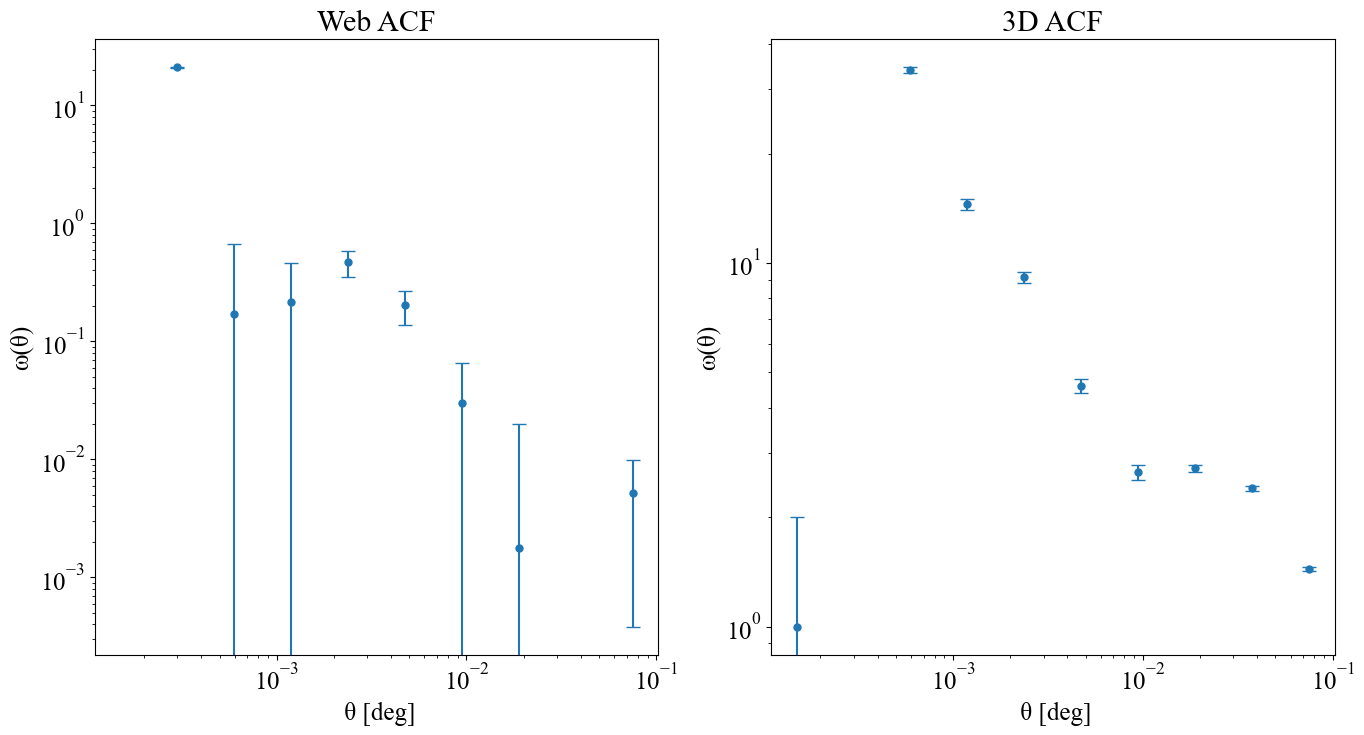

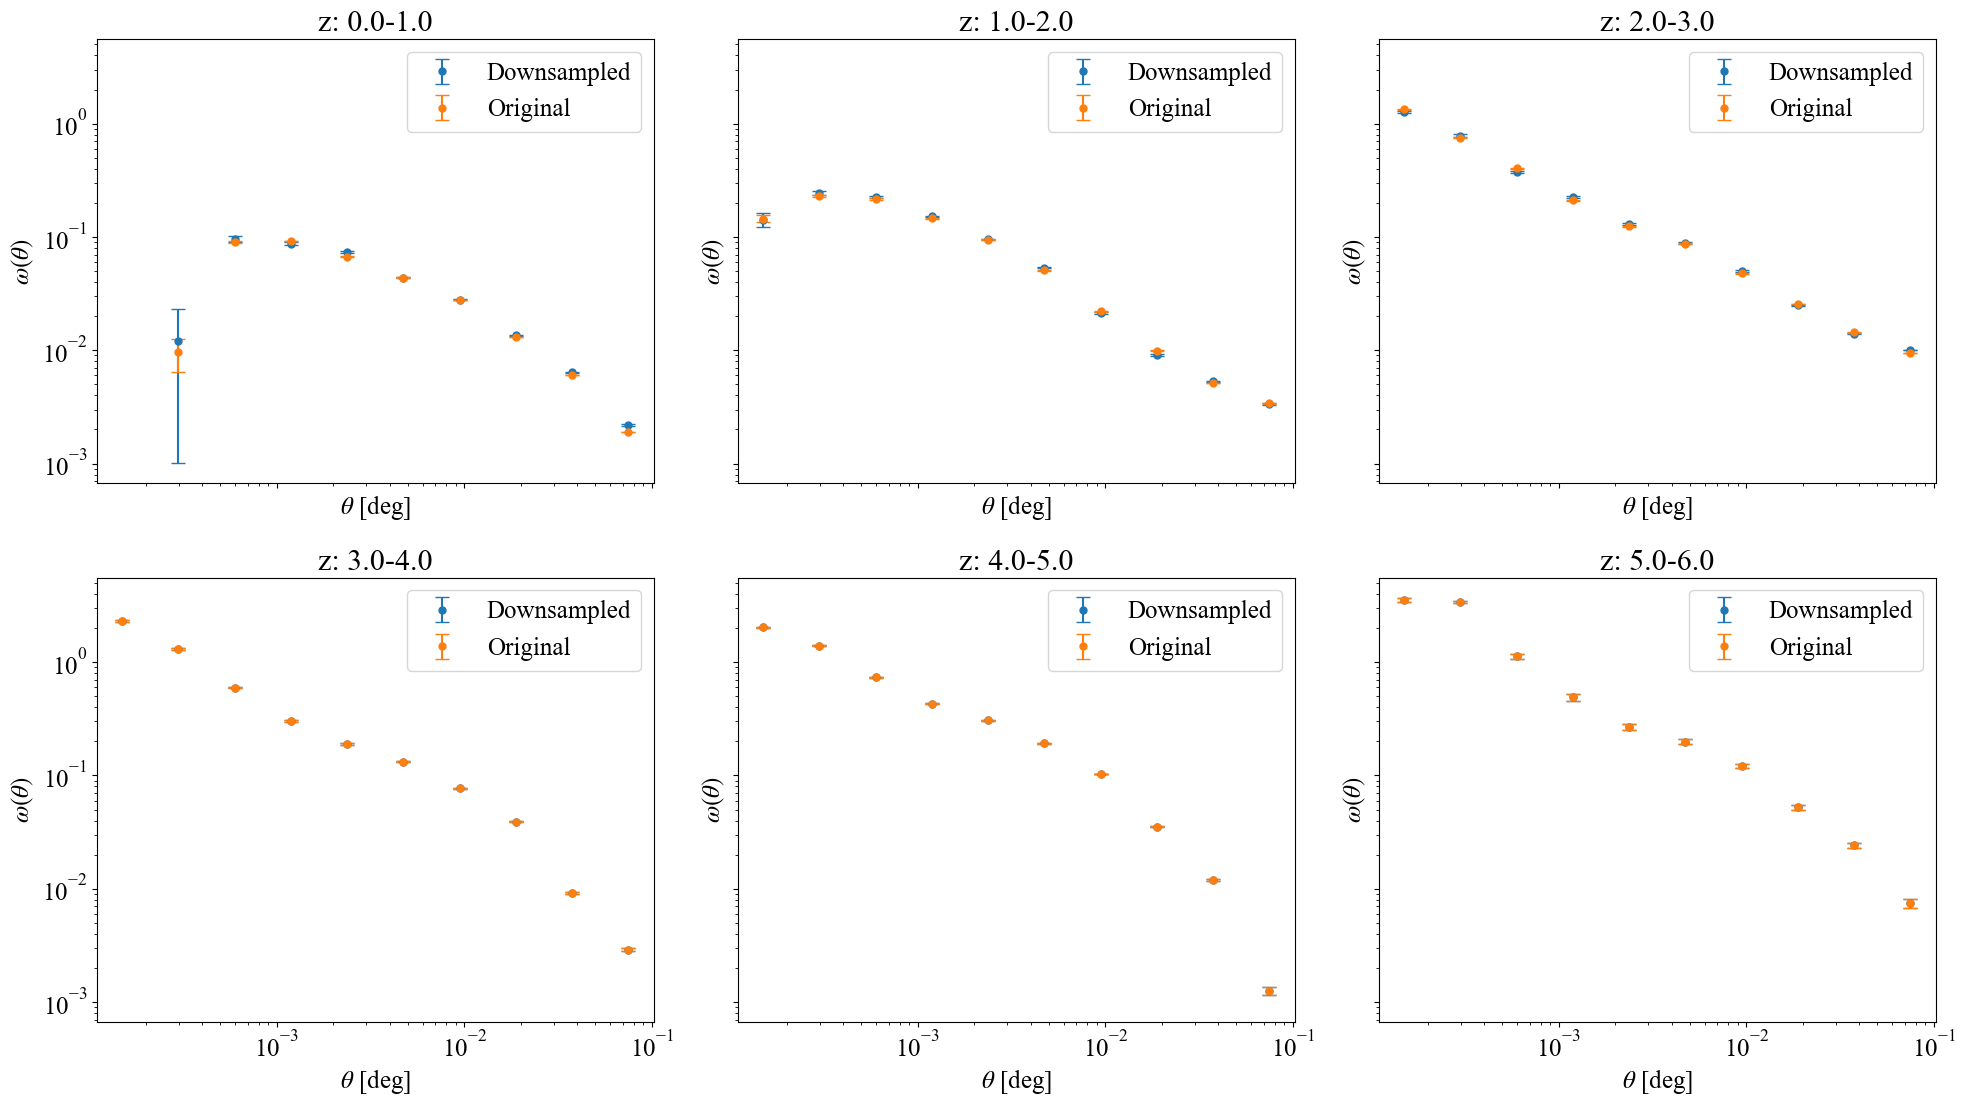

In [19]:
plt.figure(figsize=(16,8))
plt.rcParams.update({
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix",
    "font.size": 18
})
plt.subplot(1,2,1)
plt.title('Web ACF')
plt.errorbar(theta_Web_tree['ACF_LS'].to('deg').value,Omega_Web_tree['ACF_LS'], yerr = Error_Web_tree['ACF_LS'], fmt='.', ms=10, capsize=5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('\u03C9(\u03B8)')
plt.xlabel(' \u03B8 [deg]')

plt.subplot(1,2,2)
plt.title('3D ACF')
plt.errorbar(theta_3D_tree['ACF_LS'].to('deg').value,Omega_3D_tree['ACF_LS'], yerr = Error_3D_tree['ACF_LS'], fmt='.', ms=10, capsize=5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('\u03C9(\u03B8)')
plt.xlabel(' \u03B8 [deg]')
#plt.plot(theta['ACF'].to('arcsec').value,Omega['ACF']+1/N_LAE,yerr=sqrt(Var_JK['ACF']),fmt='s',ms=10,capsize=5)


fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True, sharex=True)
#fig.suptitle('Reference ACF_LS')

# Flatten axes array for easier iteration
axes = axes.ravel()

for ax, zbin in zip(axes, z_bins):
    ax.set_title(f'z: {zbin}')
    ax.errorbar(
        theta_ref_tree['ACF_LS'][zbin].to('deg').value,
        Omega_ref_tree['ACF_LS'][zbin],
        yerr=Error_ref_tree['ACF_LS'][zbin],
        fmt='.', ms=10, capsize=5, label='Downsampled'
    )
    ax.errorbar(
        theta_ref_tree_all['ACF_LS'][zbin].to('deg').value,
        Omega_ref_tree_all['ACF_LS'][zbin],
        yerr=Error_ref_tree_all['ACF_LS'][zbin],
        fmt='.', ms=10, capsize=5, label='Original'
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$\omega(\theta)$')
    ax.legend()


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
for z in z_bins:
    Omega_Web_tree['CCF_LS'][z], Error_Web_tree['CCF_LS'][z], theta_Web_tree['CCF_LS'][z] = \
        LS_BallTree.Landy_Szalay_estimator_cross_tree(
                                cosmos_web['SkyCoord'], ref_bins_small[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_Web['SkyCoord']
                                random_web3d['SkyCoord'], random_ref['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)
    

    Omega_3D_tree['CCF_LS'][z], Error_3D_tree['CCF_LS'][z], theta_3D_tree['CCF_LS'][z] = \
        LS_BallTree.Landy_Szalay_estimator_cross_tree(
                                cosmos_3D['SkyCoord'], ref_bins_small[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_3D['SkyCoord']
                                random_web3d['SkyCoord'], random_ref['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)
    


    Omega_Web_tree['CCF_DP'][z], Error_Web_tree['CCF_DP'][z], theta_Web_tree['CCF_DP'][z] = \
        LS_BallTree.Davis_Peebles_estimator_cross_tree(                                                  #, Error_Web['CCF_DP'][z]
                                cosmos_web['SkyCoord'], ref_bins_small[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_Web['SkyCoord']
                                random_web3d['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)
    

    Omega_3D_tree['CCF_DP'][z], Error_3D_tree['CCF_DP'][z], theta_3D_tree['CCF_DP'][z] = \
        LS_BallTree.Davis_Peebles_estimator_cross_tree(                                                  #, Error_3D['CCF_DP'][z]                      
                                cosmos_3D['SkyCoord'], ref_bins_small[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_3D['SkyCoord']
                                random_web3d['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)

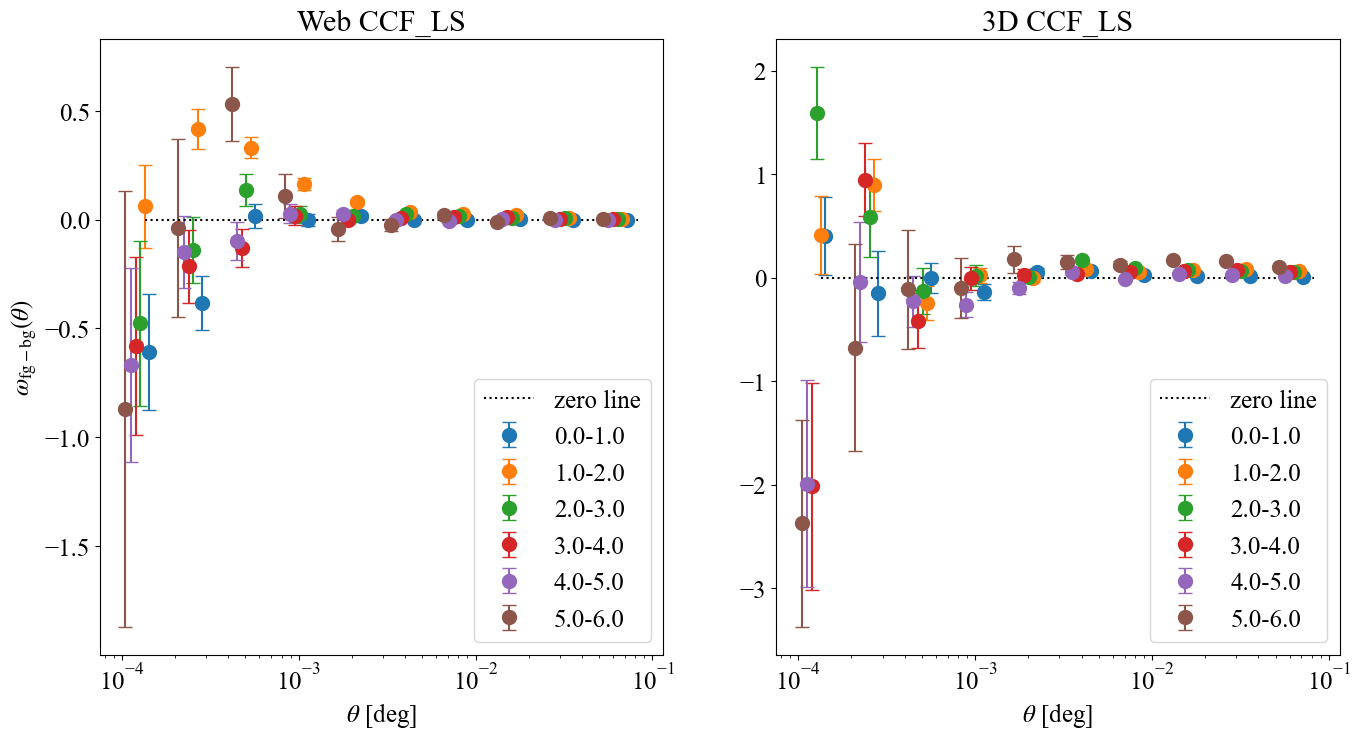

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Web CCF_LS')
sep = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_Web_tree['CCF_LS'][z].to('deg').value*sep[i], Omega_Web_tree['CCF_LS'][z],
            yerr=Error_Web_tree['CCF_LS'][z], fmt='o', ms=10,capsize=5, label=z)

    
plt.hlines(0.0, 0.9*theta_Web_tree['CCF_LS']['0.0-1.0'].min().to('deg').value,
        1.1*theta_Web_tree['CCF_LS']['0.0-1.0'].max().to('deg').value,
        linestyle='dotted',color='black', label='zero line')
plt.xscale('log')
#plt.yscale('symlog')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
plt.legend()

plt.subplot(1,2,2)
plt.title('3D CCF_LS')
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_3D_tree['CCF_LS'][z].to('deg').value*sep[i], Omega_3D_tree['CCF_LS'][z],
            yerr=Error_3D_tree['CCF_LS'][z], fmt='o', ms=10,capsize=5, label=z)

    
plt.hlines(0.0, 0.9*theta_3D_tree['CCF_LS']['0.0-1.0'].min().to('deg').value,
        1.1*theta_3D_tree['CCF_LS']['0.0-1.0'].max().to('deg').value,
        linestyle='dotted',color='black', label='zero line')
plt.xscale('log')
#plt.grid()
#plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
#plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

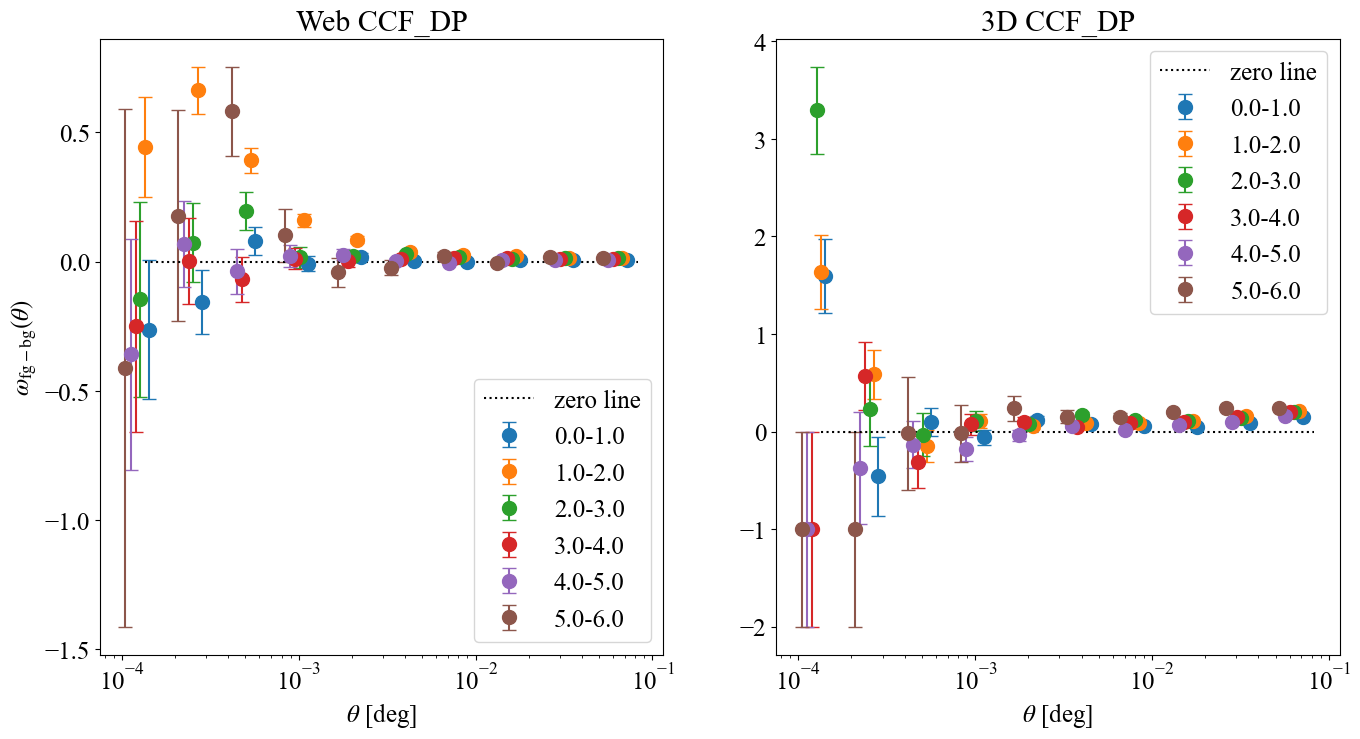

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Web CCF_DP')
sep = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_Web_tree['CCF_DP'][z].to('deg').value*sep[i], Omega_Web_tree['CCF_DP'][z],
            yerr=Error_Web_tree['CCF_DP'][z], fmt='o', ms=10,capsize=5, label=z)

plt.hlines(0.0, 0.9*theta_Web_tree['CCF_DP']['0.0-1.0'].min().to('deg').value,
        1.1*theta_Web_tree['CCF_DP']['0.0-1.0'].max().to('deg').value,
        linestyle='dotted',color='black', label = 'zero line')
plt.xscale('log')
#plt.yscale('symlog')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
plt.legend()

plt.subplot(1,2,2)
plt.title('3D CCF_DP')
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_3D_tree['CCF_DP'][z].to('deg').value*sep[i], Omega_3D_tree['CCF_DP'][z],
            yerr=Error_3D_tree['CCF_DP'][z], fmt='o', ms=10,capsize=5, label=z)
    
plt.hlines(0.0, 0.9*theta_3D_tree['CCF_DP']['0.0-1.0'].min().to('deg').value,
        1.1*theta_3D_tree['CCF_DP']['0.0-1.0'].max().to('deg').value,
        linestyle='dotted',color='black', label = 'zero line')
plt.xscale('log')
#plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
#plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

In [17]:
def compare_estimators(scales, xi_ls, err_ls, xi_dp, err_dp, 
                       xlabel=r'$\theta$ [deg]', title="LS vs DP"):
    """
    Compare Landy–Szalay and Davis–Peebles correlation results with error propagation.

    Parameters
    ----------
    scales : array
        Separation bins (e.g. r or theta).
    xi_ls : array
        Correlation function from Landy–Szalay estimator.
    err_ls : array
        1σ errors on xi_ls.
    xi_dp : array
        Correlation function from Davis–Peebles estimator.
    err_dp : array
        1σ errors on xi_dp.
    xlabel : str
        Label for the x-axis (default: r or θ).
    title : str
        Figure title.

    Returns
    -------
    ratio, ratio_err, residual, residual_err
    """
    xi_ls = np.asarray(xi_ls)
    xi_dp = np.asarray(xi_dp)
    err_ls = np.asarray(err_ls)
    err_dp = np.asarray(err_dp)

    # Residual and its error
    residual = xi_dp - xi_ls
    residual_err = np.sqrt(err_dp**2 + err_ls**2)

    # Ratio and its error (avoid division by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = xi_dp / xi_ls
        ratio_err = np.abs(ratio) * np.sqrt(
            (err_dp/xi_dp)**2 + (err_ls/xi_ls)**2
        )

        # Mask invalid entries (NaN/inf when xi=0)
        ratio[~np.isfinite(ratio)] = np.nan
        ratio_err[~np.isfinite(ratio_err)] = np.nan

    # --- Plotting ---
    fig, axes = plt.subplots(3, 1, figsize=(6, 11), sharex=True,
                             gridspec_kw={'height_ratios': [2, 1, 1]})

    # Correlation functions
    axes[0].errorbar(scales, xi_ls, yerr=err_ls, fmt='o-', label='Landy–Szalay')
    axes[0].errorbar(scales, xi_dp, yerr=err_dp, fmt='s--', label='Davis–Peebles')
    axes[0].set_ylabel(r"$\xi$")
    axes[0].legend()
    #axes[0].set_xscale('log')
    axes[0].set_title(title)

    # Ratio
    axes[1].errorbar(scales, ratio, yerr=ratio_err, fmt='o-', color='purple')
    axes[1].axhline(1.0, color='k', ls='--')
    axes[1].set_ylabel(r"$\xi_{DP}/\xi_{LS}$")
    #axes[1].set_xscale('log')
    # Residual
    axes[2].errorbar(scales, residual, yerr=residual_err, fmt='o-', color='darkgreen')
    axes[2].axhline(0.0, color='k', ls='--')
    axes[2].set_xlabel(xlabel)
    axes[2].set_ylabel(r"$\xi_{DP}-\xi_{LS}$")
    #axes[2].set_xscale('log')
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

    return ratio, ratio_err, residual, residual_err

In [23]:
from python_files import compare_estimators as ce

In [24]:
xi_ls=Omega_Web_tree['CCF_LS']['3.0-4.0']
err_ls=Error_Web_tree['CCF_LS']['3.0-4.0']
xi_dp = Omega_Web_tree['CCF_DP']['3.0-4.0']
err_dp=Error_Web_tree['CCF_DP']['3.0-4.0']

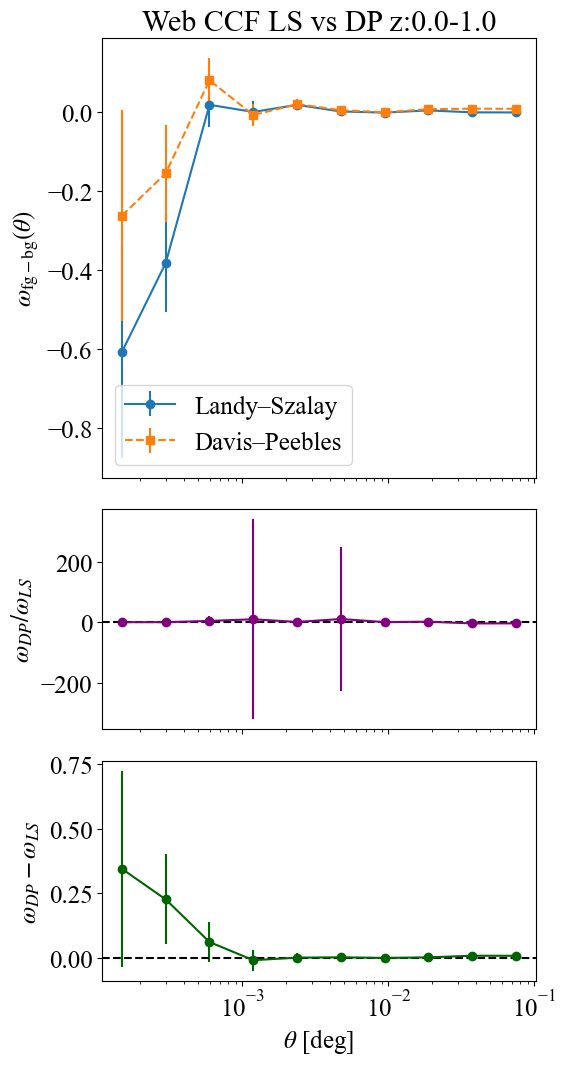

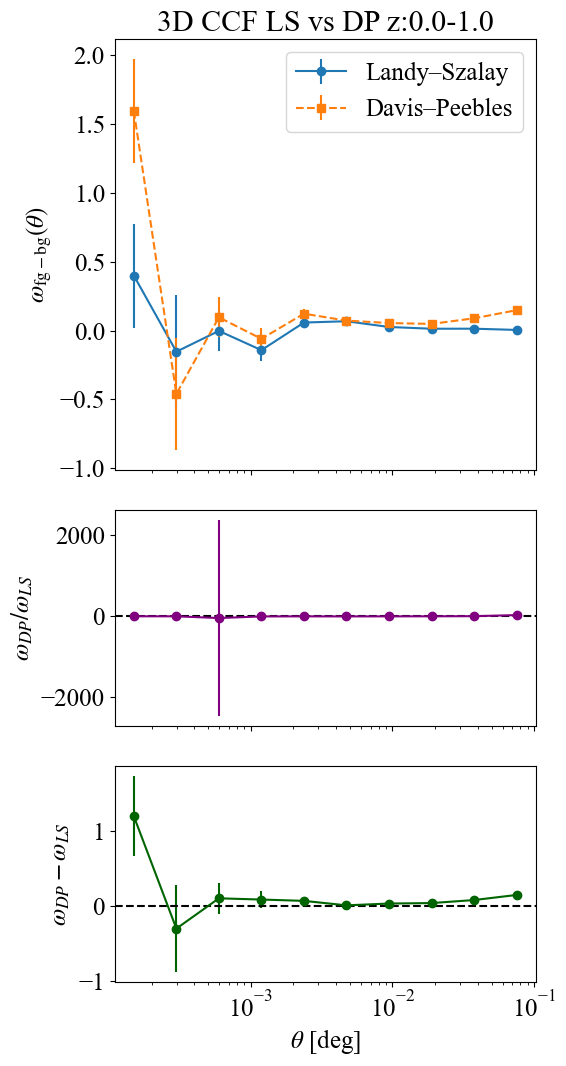

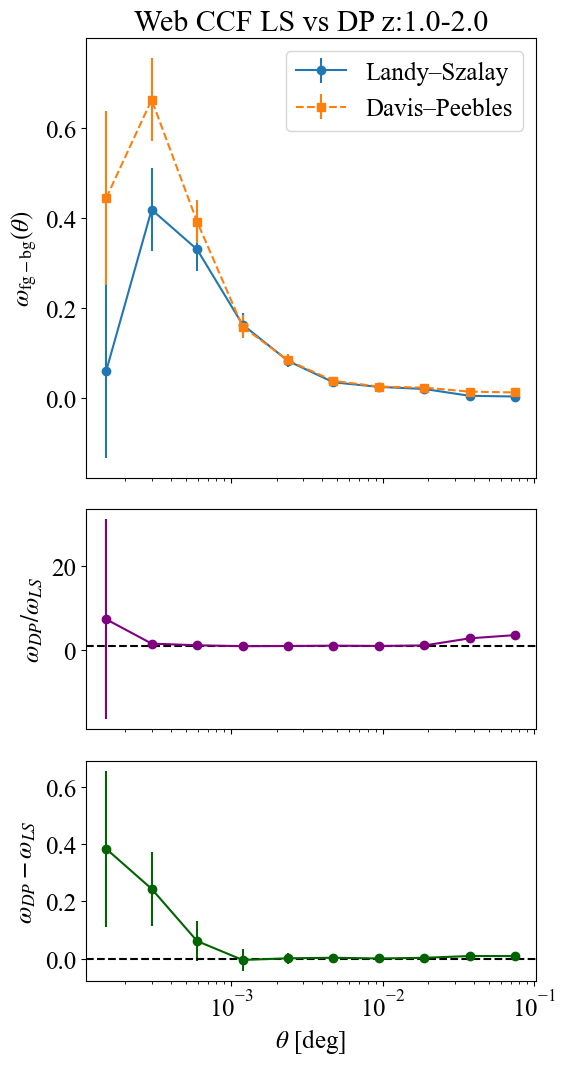

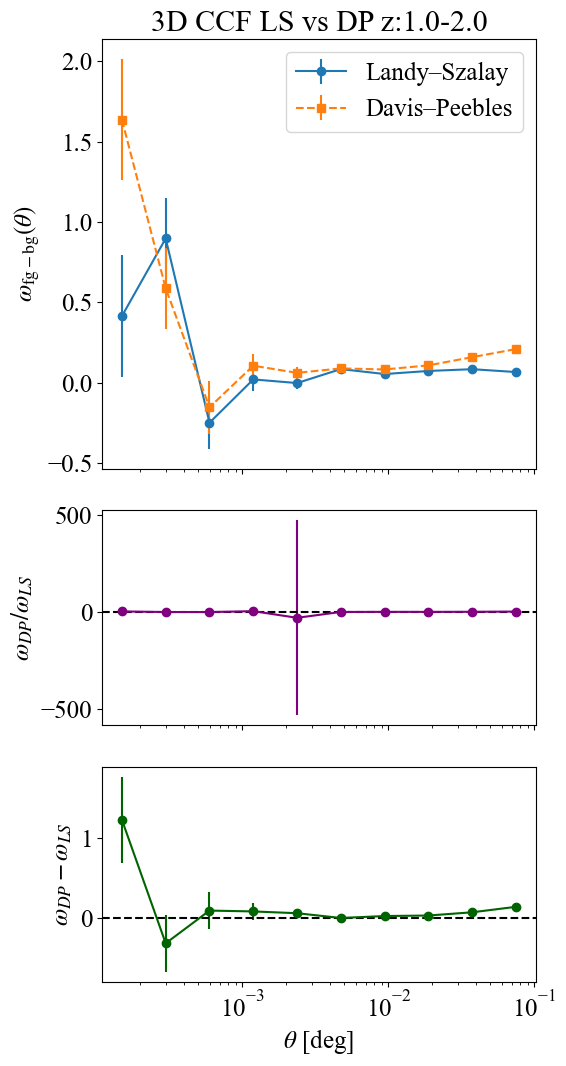

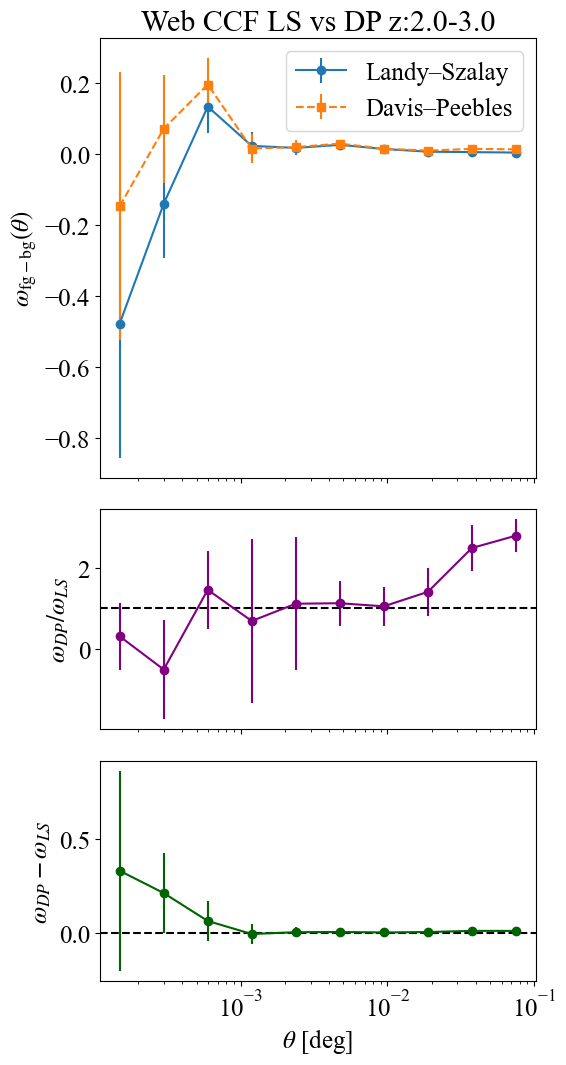

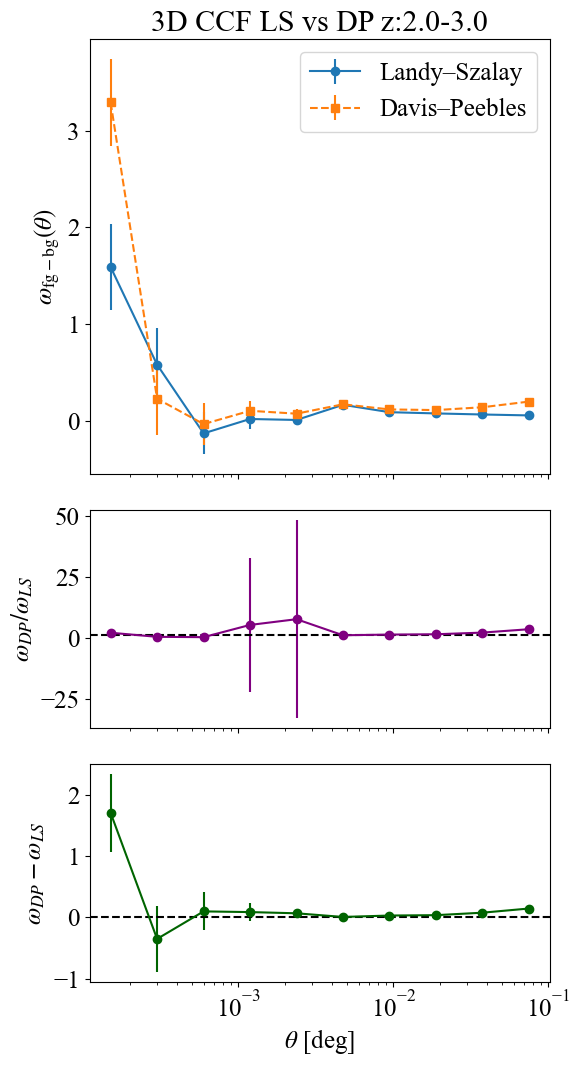

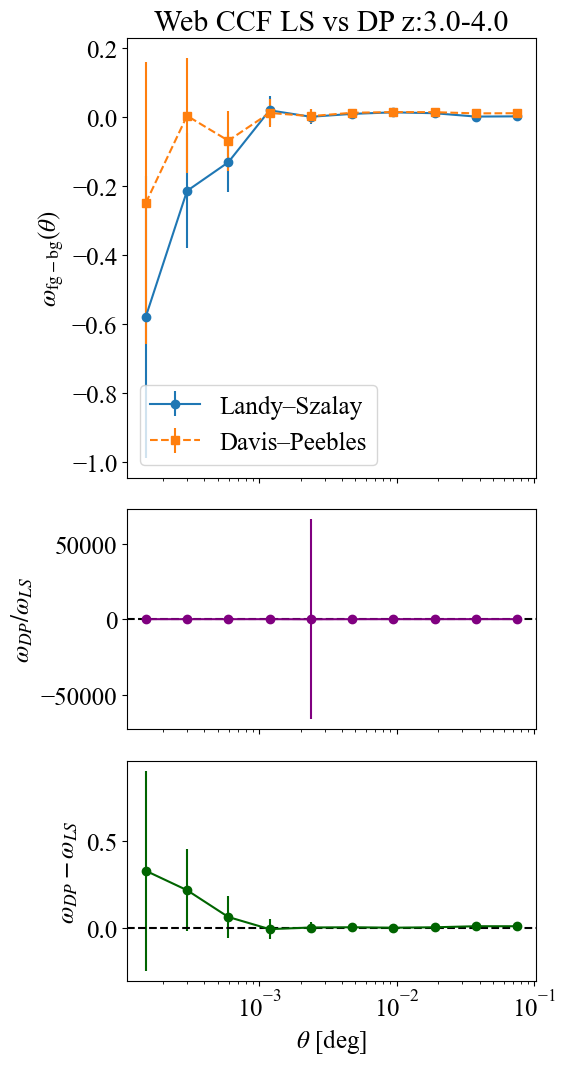

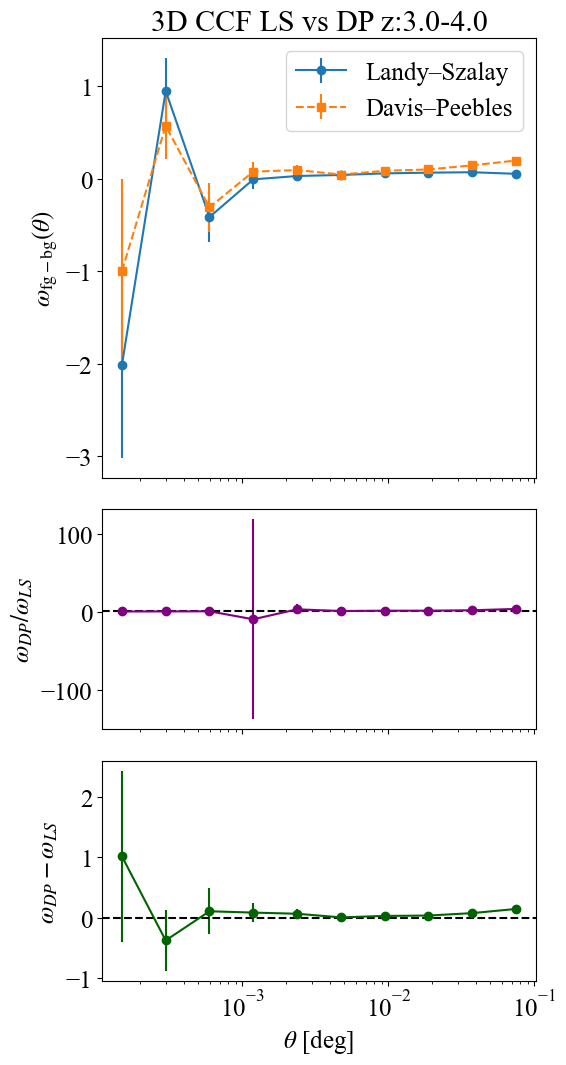

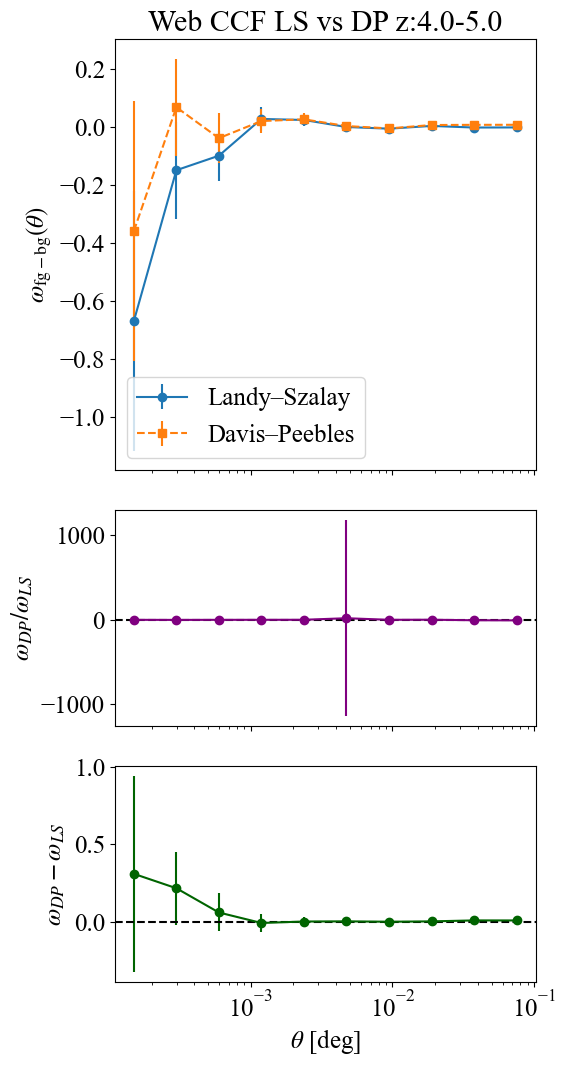

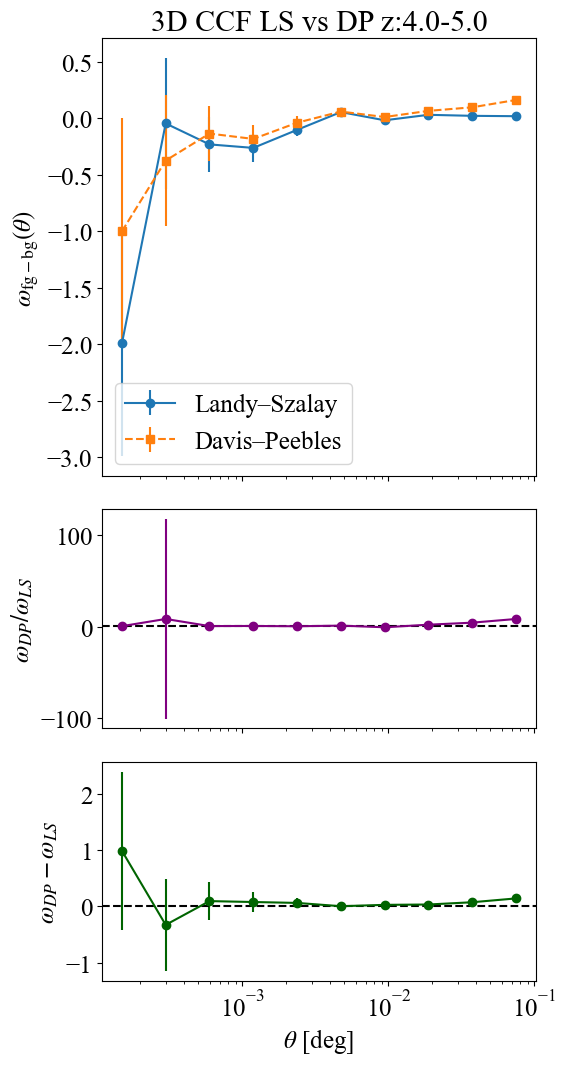

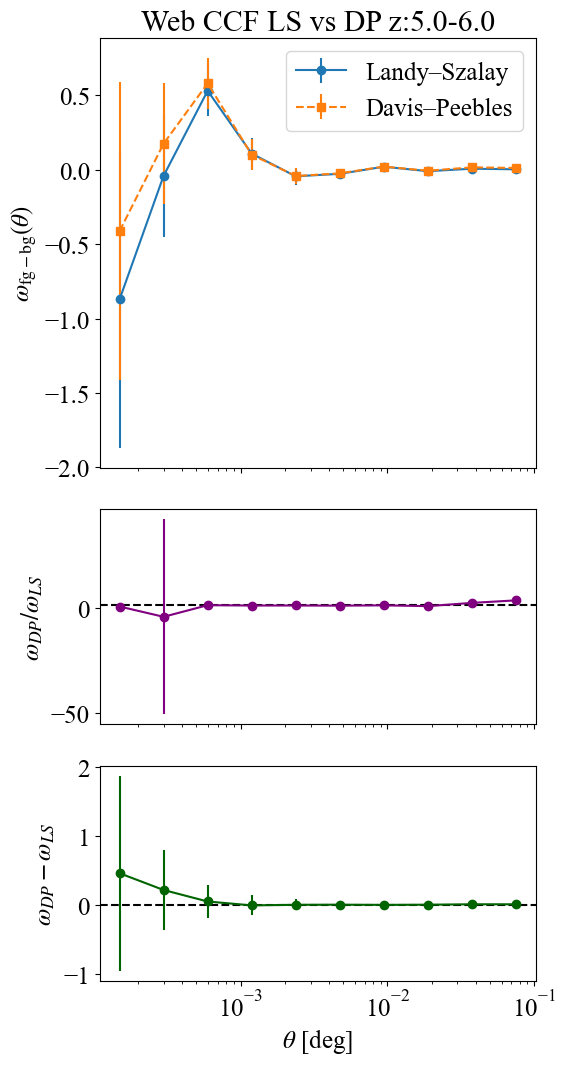

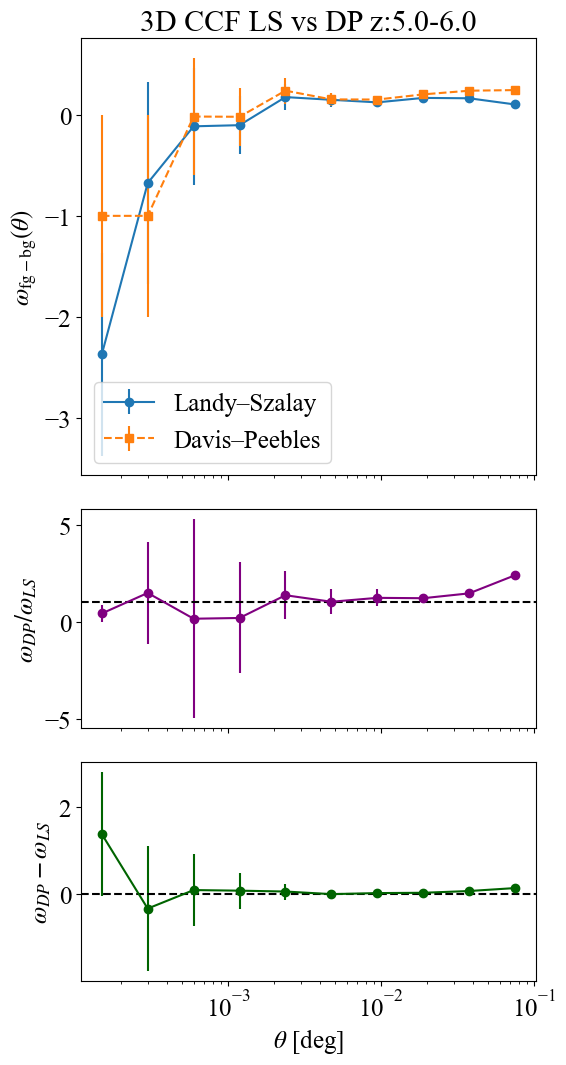

In [25]:
ratio_web, ratio_err_web, residual_web, residual_err_web = {}, {}, {}, {}
ratio_3d, ratio_err_3d, residual_3d, residual_err_3d = {}, {}, {}, {}
for z in z_bins:
    ratio_web[z], ratio_err_web[z], residual_web[z], residual_err_web[z] = ce.compare_estimators_over_theta(theta_Web_tree['CCF_DP'][z].to('deg').value,
                                                                                               xi_ls=Omega_Web_tree['CCF_LS'][z],
                                                                                               err_ls=Error_Web_tree['CCF_LS'][z],
                                                                                                 xi_dp = Omega_Web_tree['CCF_DP'][z],
                                                                                                   err_dp=Error_Web_tree['CCF_DP'][z],
                                                                                                     title=f'Web CCF LS vs DP z:{z}')
    ratio_3d[z], ratio_err_3d[z], residual_3d[z], residual_err_3d[z] = ce.compare_estimators_over_theta(theta_3D_tree['CCF_DP'][z].to('deg').value,
                                                                                           xi_ls=Omega_3D_tree['CCF_LS'][z],
                                                                                           err_ls=Error_3D_tree['CCF_LS'][z],
                                                                                             xi_dp = Omega_3D_tree['CCF_DP'][z],
                                                                                               err_dp=Error_3D_tree['CCF_DP'][z],
                                                                                                 title=f'3D CCF LS vs DP z:{z}')

In [34]:
angles = theta_Web_tree['CCF_DP']['0.0-1.0'].to('deg').value

In [35]:
def extract_values_errors(Omega, Error, z_bins, angles):
    values, errors = [], []
    
    for angle in range(len(angles)):
        value, error = [], []
        for z in z_bins:
            value.append(Omega[z][angle])
            error.append(Error[z][angle])
            
        values.append(value)
        errors.append(error)
    
    return values, errors

values_web_DP, errors_web_DP = extract_values_errors(
    Omega_Web_tree['CCF_DP'], Error_Web_tree['CCF_DP'], z_bins, angles
)
# values_web_LS,  errors_web_LS = extract_values_errors(
#     Omega_Web['CCF_LS'], Error_Web['CCF_LS'], z_bins, angles
# )

values_3D_DP, errors_3D_DP = extract_values_errors(
    Omega_3D_tree['CCF_DP'], Error_3D_tree['CCF_DP'], z_bins, angles
)

# values_3D_LS, errors_3D_LS = extract_values_errors(
#     Omega_3D['CCF_LS'], Error_3D['CCF_LS'], z_bins, angles
# )

values_3D_tree_LS, errors_3D_tree_LS = extract_values_errors(
    Omega_3D_tree['CCF_LS'], Error_3D_tree['CCF_LS'], z_bins, angles
)

values_web_tree_LS,  errors_web_tree_LS = extract_values_errors(
    Omega_Web_tree['CCF_LS'], Error_Web_tree['CCF_LS'], z_bins, angles
)

In [36]:
angle_arcmin = theta_Web_tree['CCF_DP']['0.0-1.0'].to('arcmin').value

In [37]:
for angle in angles:
    print(f'{angle:.5f}')

0.00015
0.00030
0.00060
0.00119
0.00237
0.00474
0.00945
0.01885
0.03762
0.07506


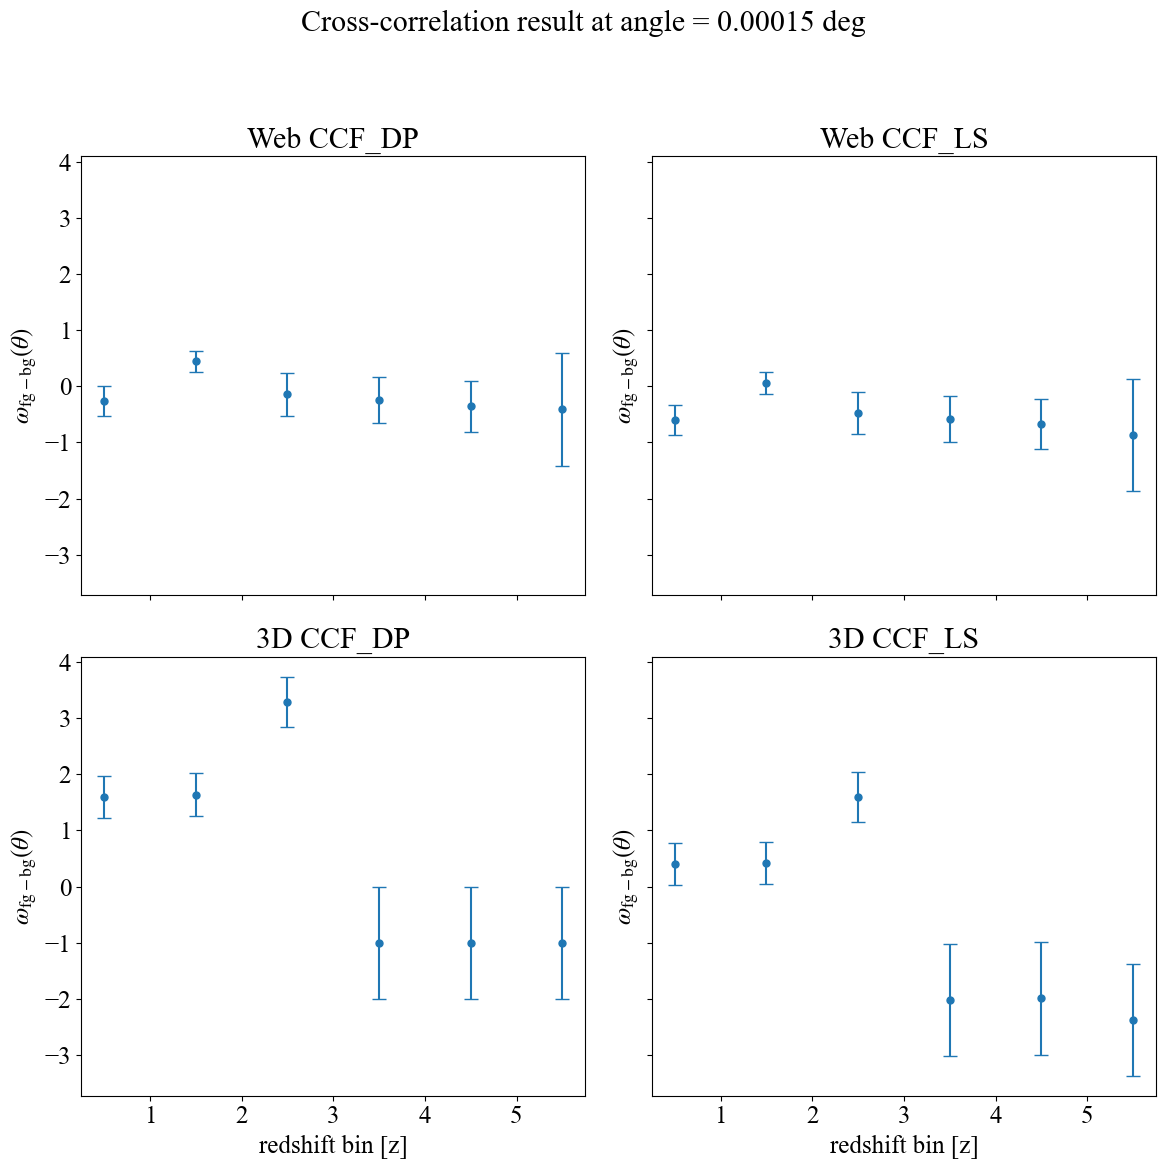

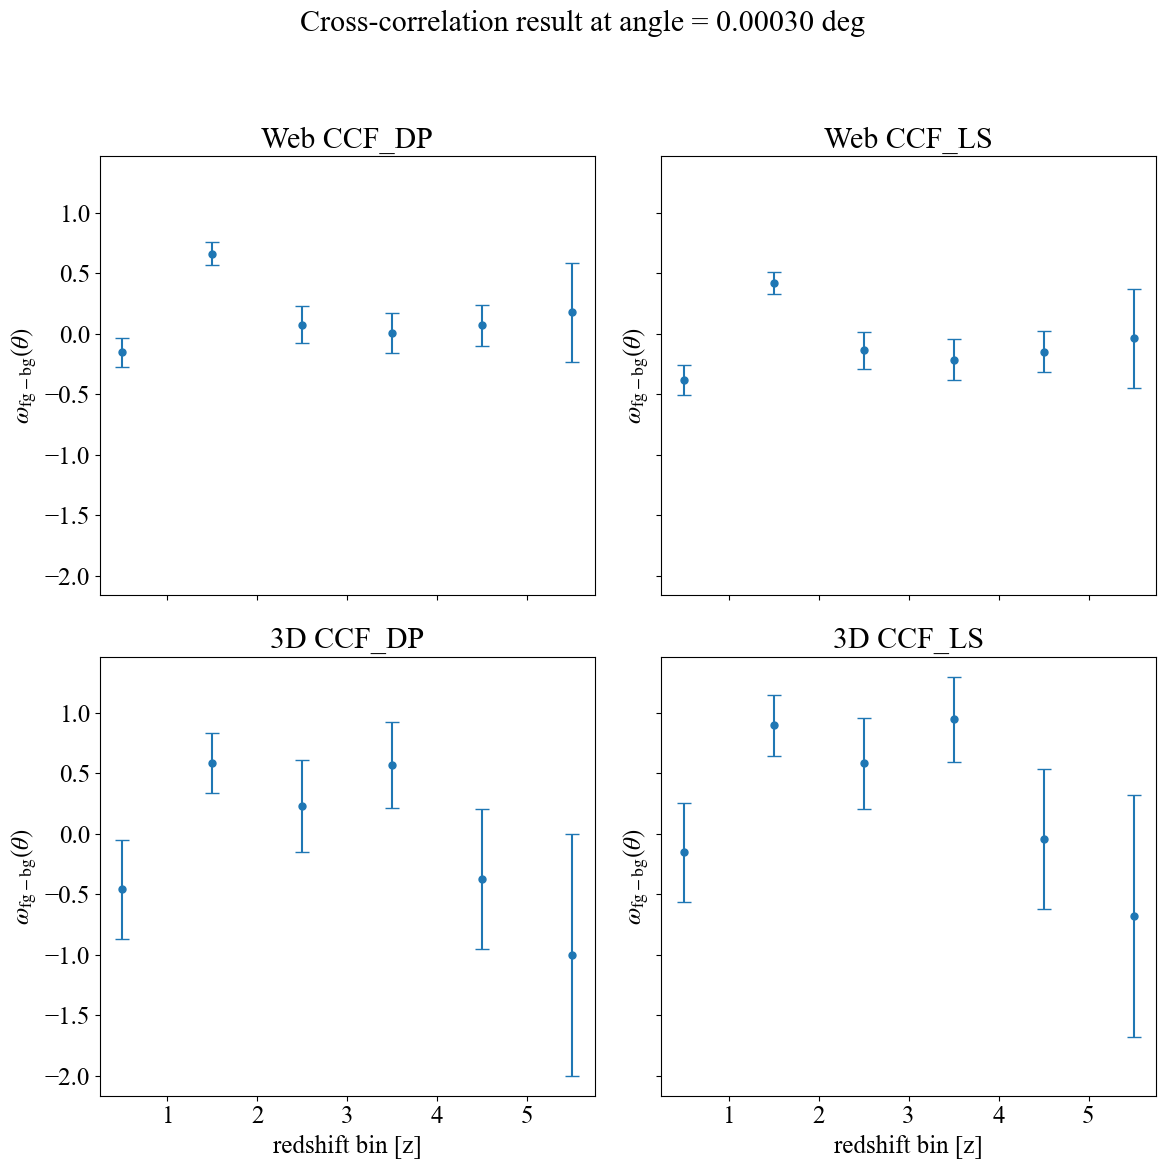

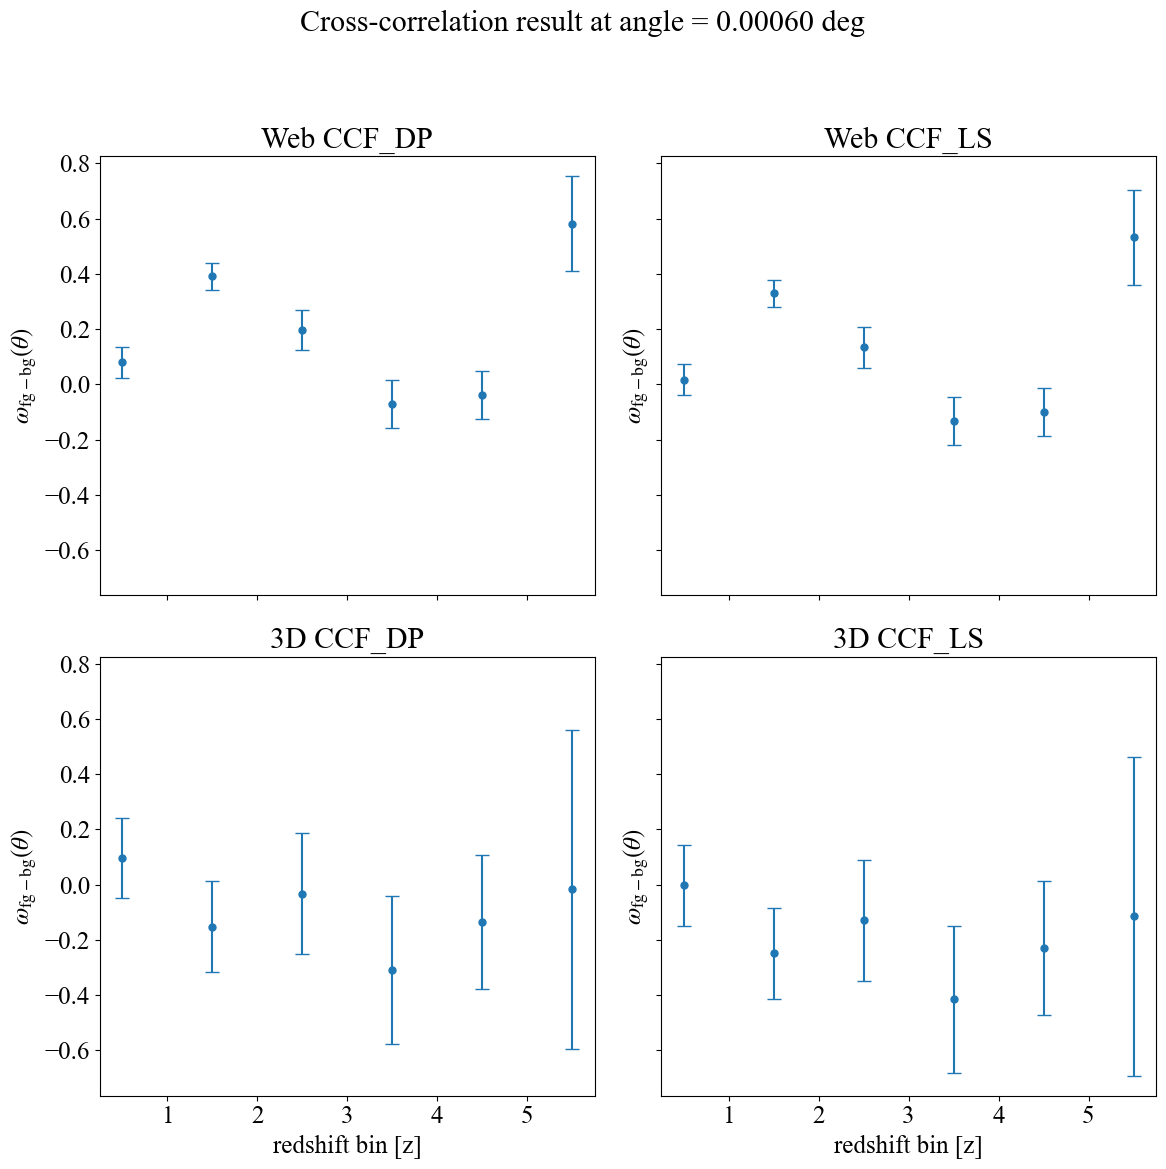

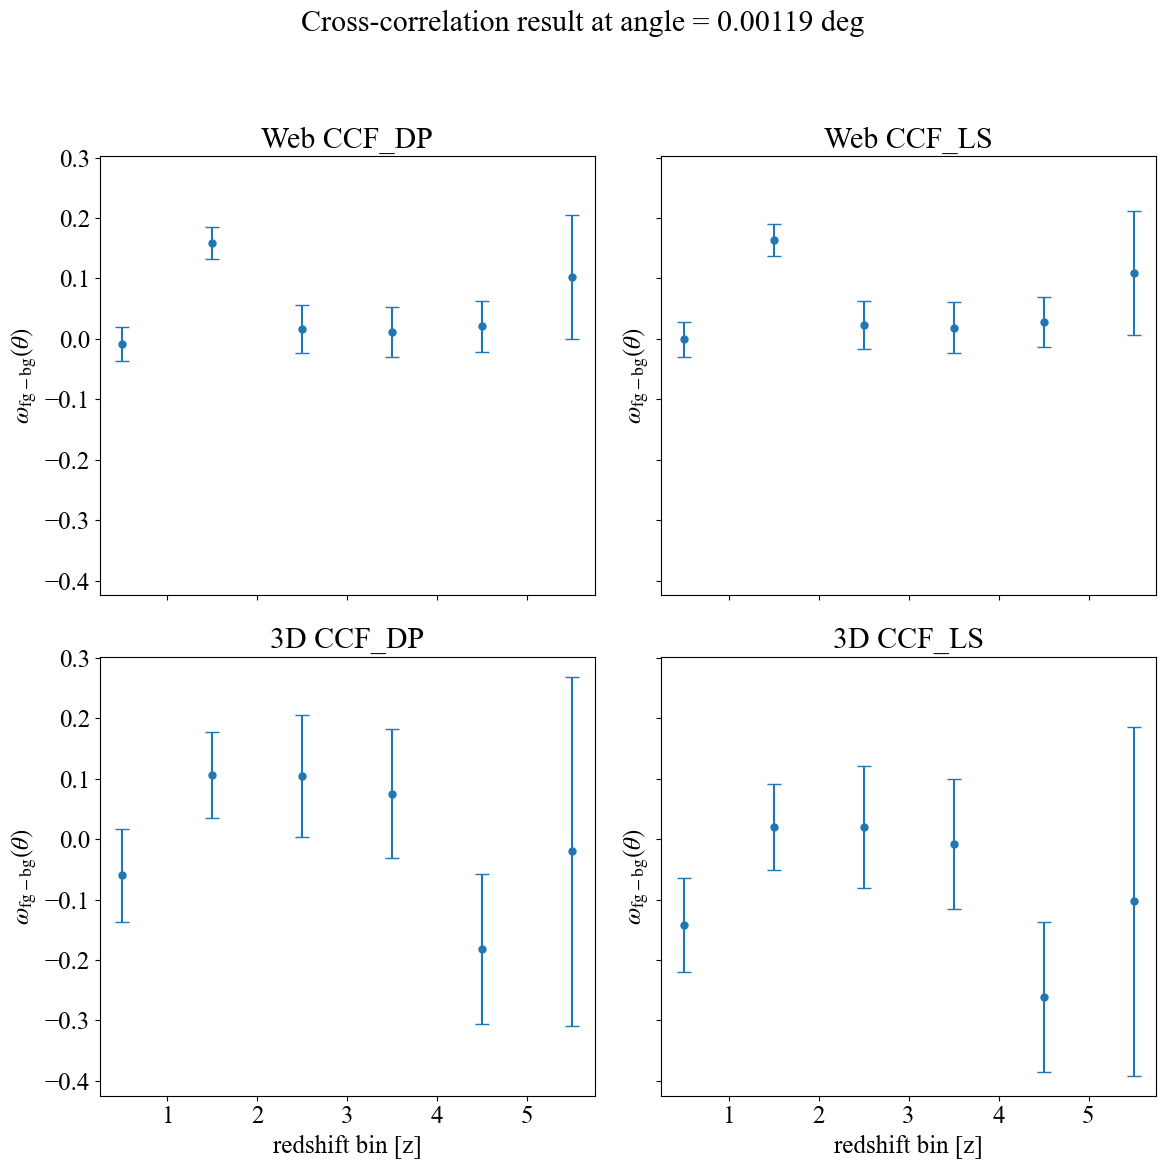

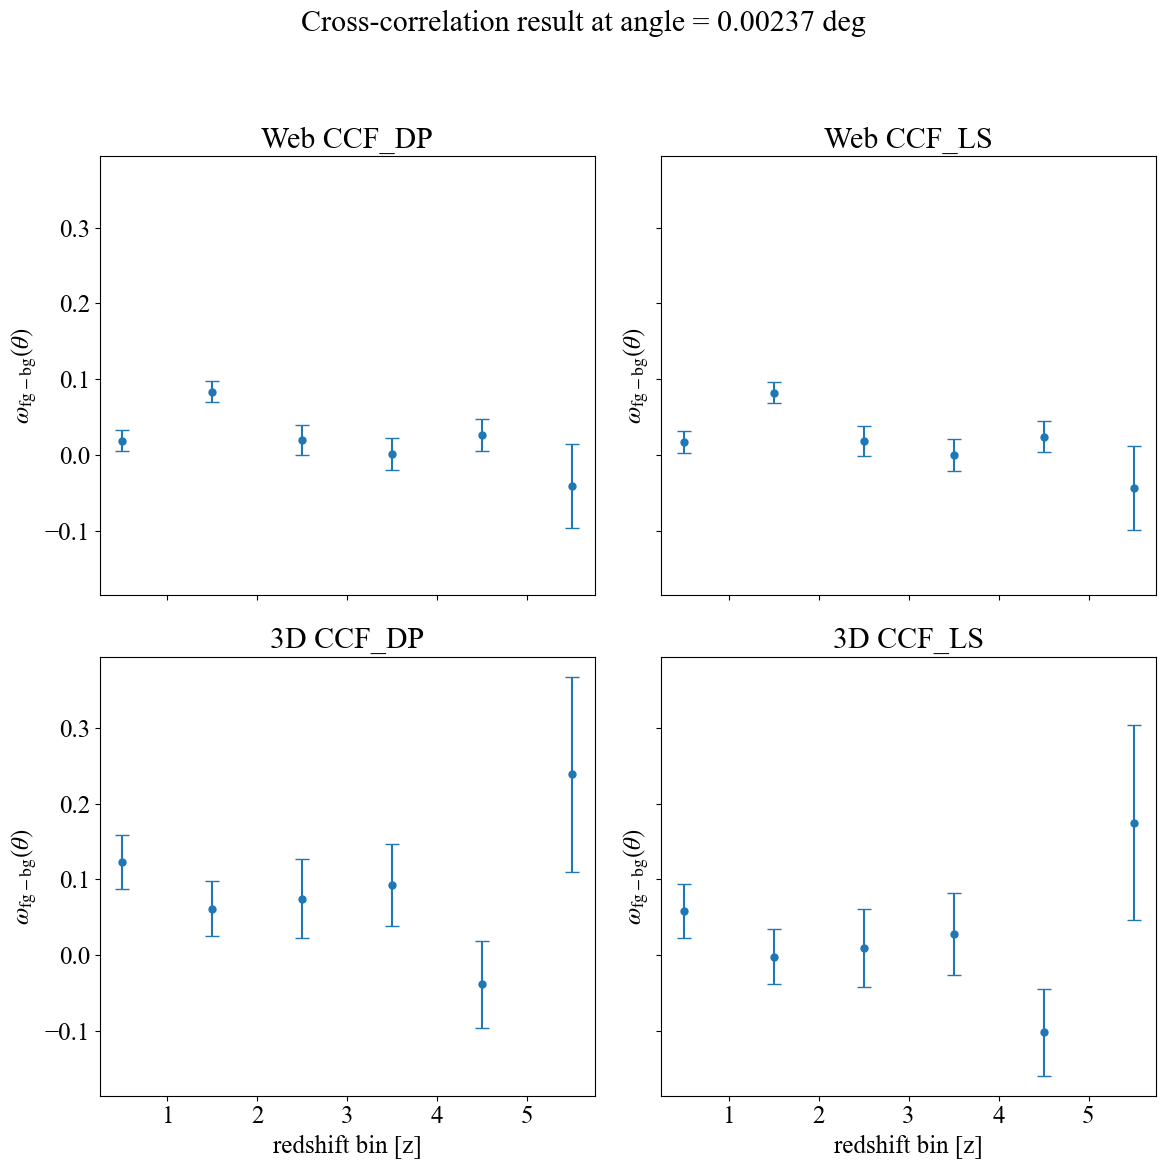

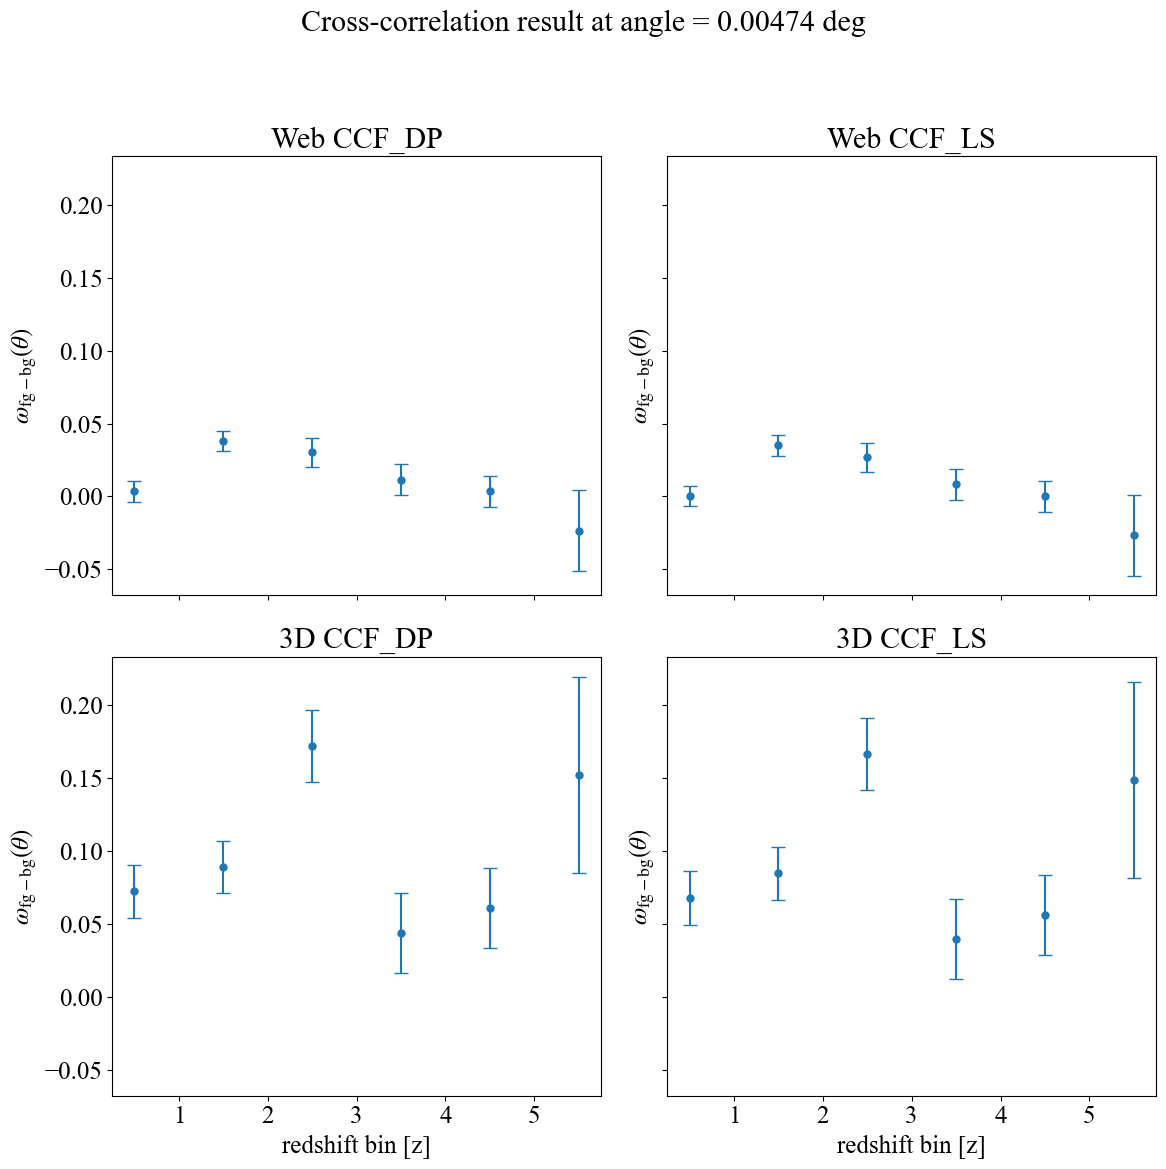

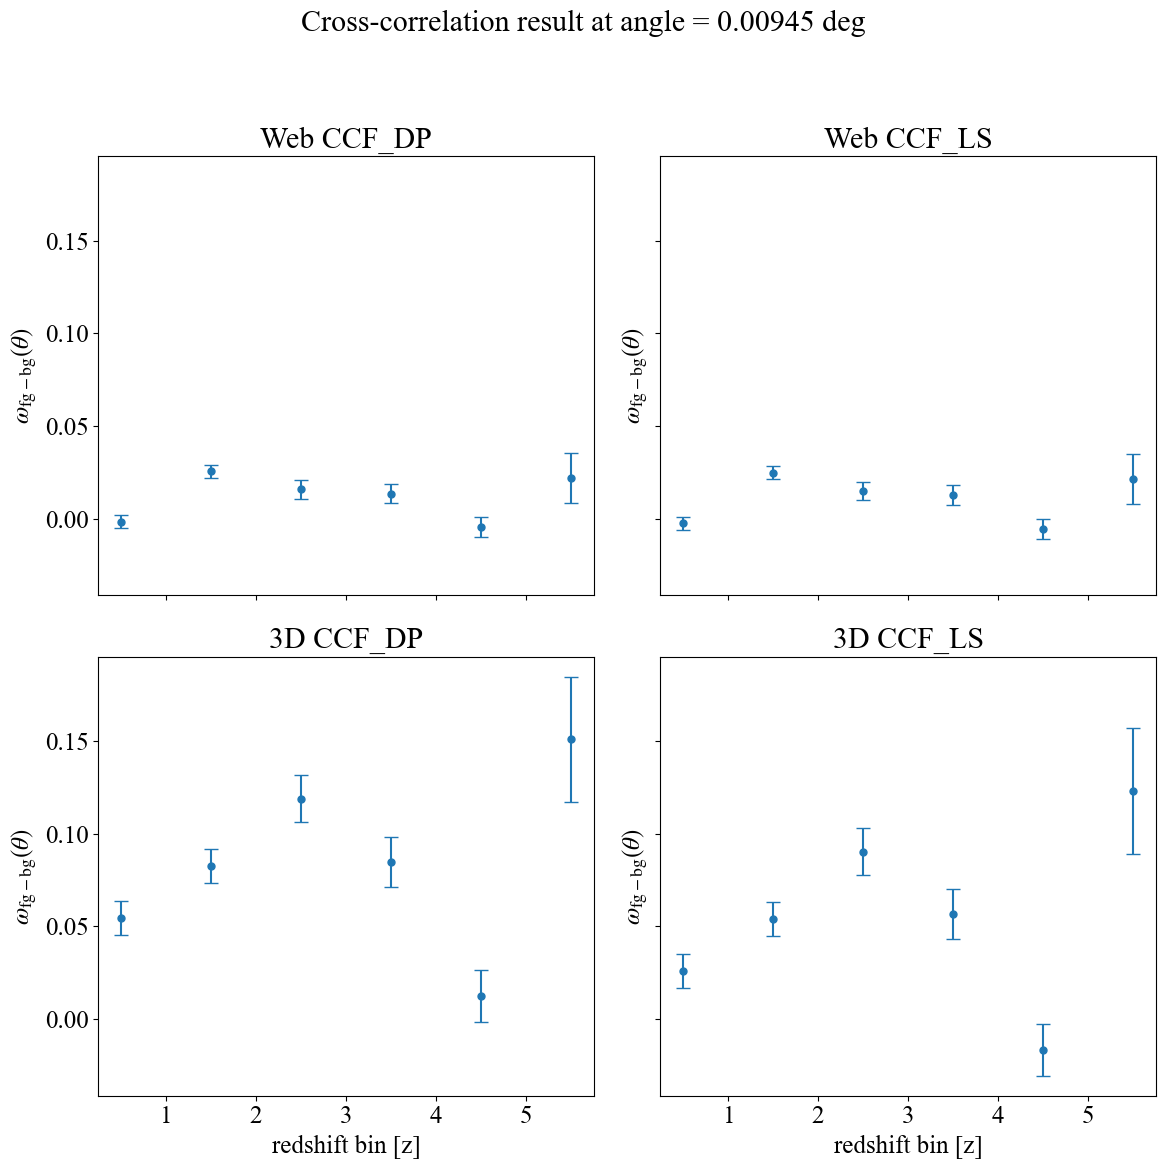

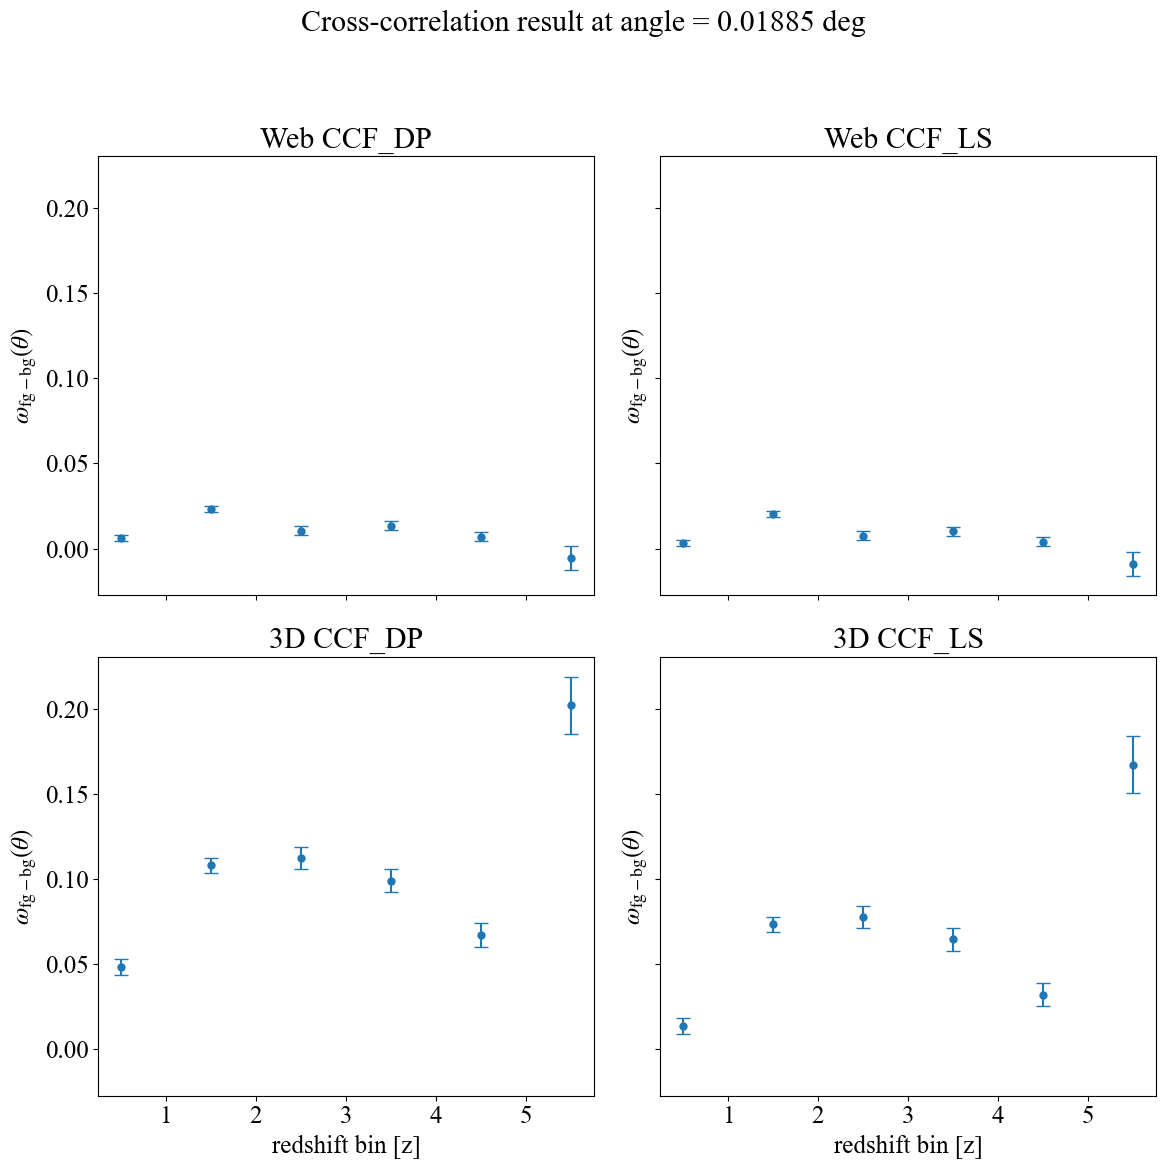

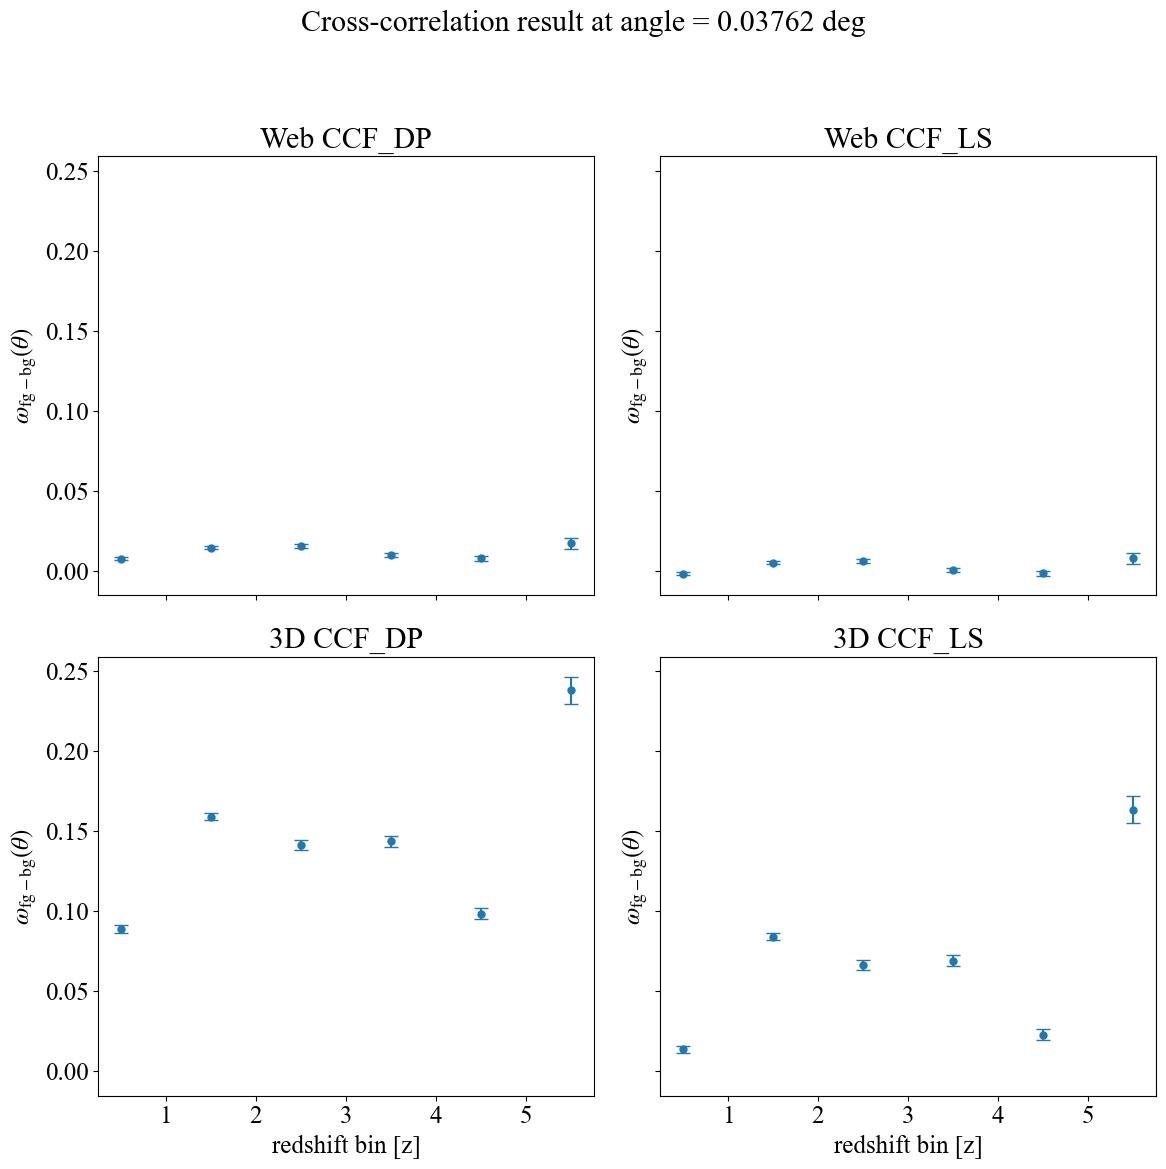

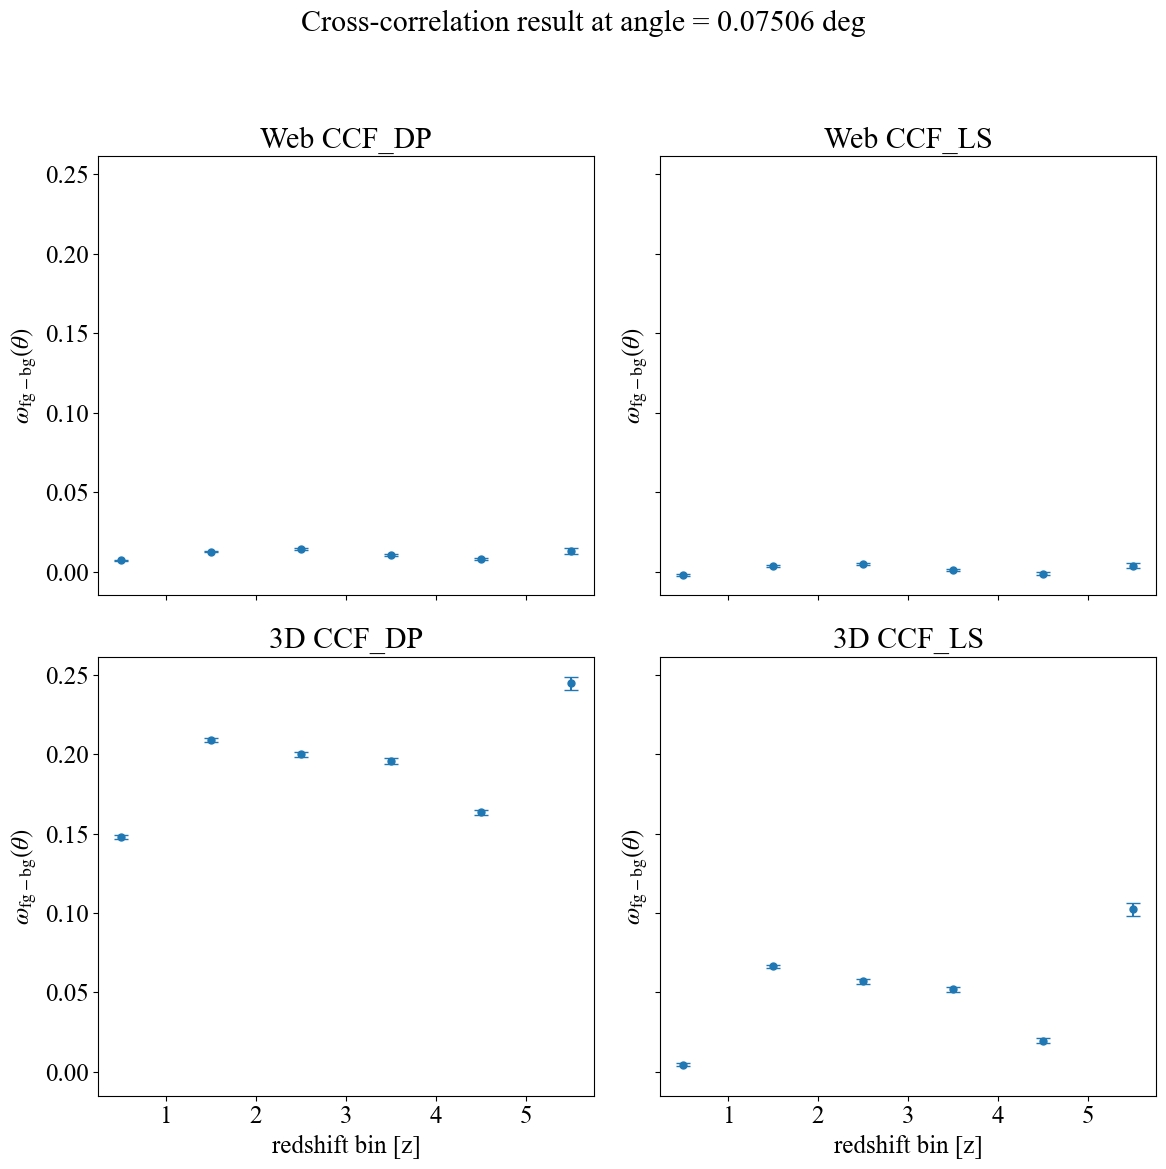

In [38]:
z_edges = np.array([0.,1.,2.,3.,4.,5.,6.])
z_centers = 0.5*(z_edges[:-1]+z_edges[1:])

for j in range(len(values_web_DP)):
    fig, axes = plt.subplots(2, 2, figsize=(12,12), sharey=True)
    fig.suptitle(f'Cross-correlation result at angle = {angles[j]:.5f} deg')

#     axes[0,0].set_title('Web CCF_LS')
#     #axes[0,0].set_xlabel('redshift bin')
#     axes[0,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
#     axes[0,0].errorbar(z_bins, values_web_LS[j],
#             yerr=errors_web_LS[j], fmt='.', ms=10,capsize=5, label=z)
#     axes[0,0].tick_params(labelbottom=False)
#     #axes[0,0].grid()

    axes[0,0].set_title('Web CCF_DP')
    #axes[0,0].set_xlabel('redshift bin')
    axes[0,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
    axes[0,0].errorbar(z_centers, values_web_DP[j],
            yerr=errors_web_DP[j], fmt='.', ms=10,capsize=5, label=z)
    axes[0,0].tick_params(labelbottom=False)
    #axes[0,0].grid()

    axes[0,1].set_title('Web CCF_LS')
    #axes[0,1].set_xlabel('redshift bin')
    axes[0,1].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
    axes[0,1].errorbar(z_centers, values_web_tree_LS[j],
            yerr=errors_web_tree_LS[j], fmt='.', ms=10,capsize=5, label=z)
    #axes[0,1].scatter(z_centers, values_web_DP[j])
    axes[0,1].tick_params(labelbottom=False)
    #axes[0,1].grid()

#     axes[1,0].set_title('3D CCF_LS')
#     axes[1,0].set_xlabel('redshift bin')
#     axes[1,0].errorbar(z_centers, values_3D_LS[j],
#             yerr=errors_3D_LS[j], fmt='.', ms=10,capsize=5, label=z)
#     axes[1,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
#     #axes[1,0].scatter(z_centers, values_web_DP[j])
#     axes[1,0].grid()

    axes[1,0].set_title('3D CCF_DP')
    axes[1,0].set_xlabel('redshift bin [z]')
    axes[1,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
    axes[1,0].errorbar(z_centers, values_3D_DP[j],
            yerr=errors_3D_DP[j], fmt='.', ms=10,capsize=5, label=z)
    #axes[1,0].grid()

    axes[1,1].set_title('3D CCF_LS')
    axes[1,1].set_xlabel('redshift bin [z]')
    axes[1,1].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
    axes[1,1].errorbar(z_centers, values_3D_tree_LS[j],
            yerr=errors_3D_tree_LS[j], fmt='.', ms=10,capsize=5, label=z)
    #axes[1,1].grid()
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle

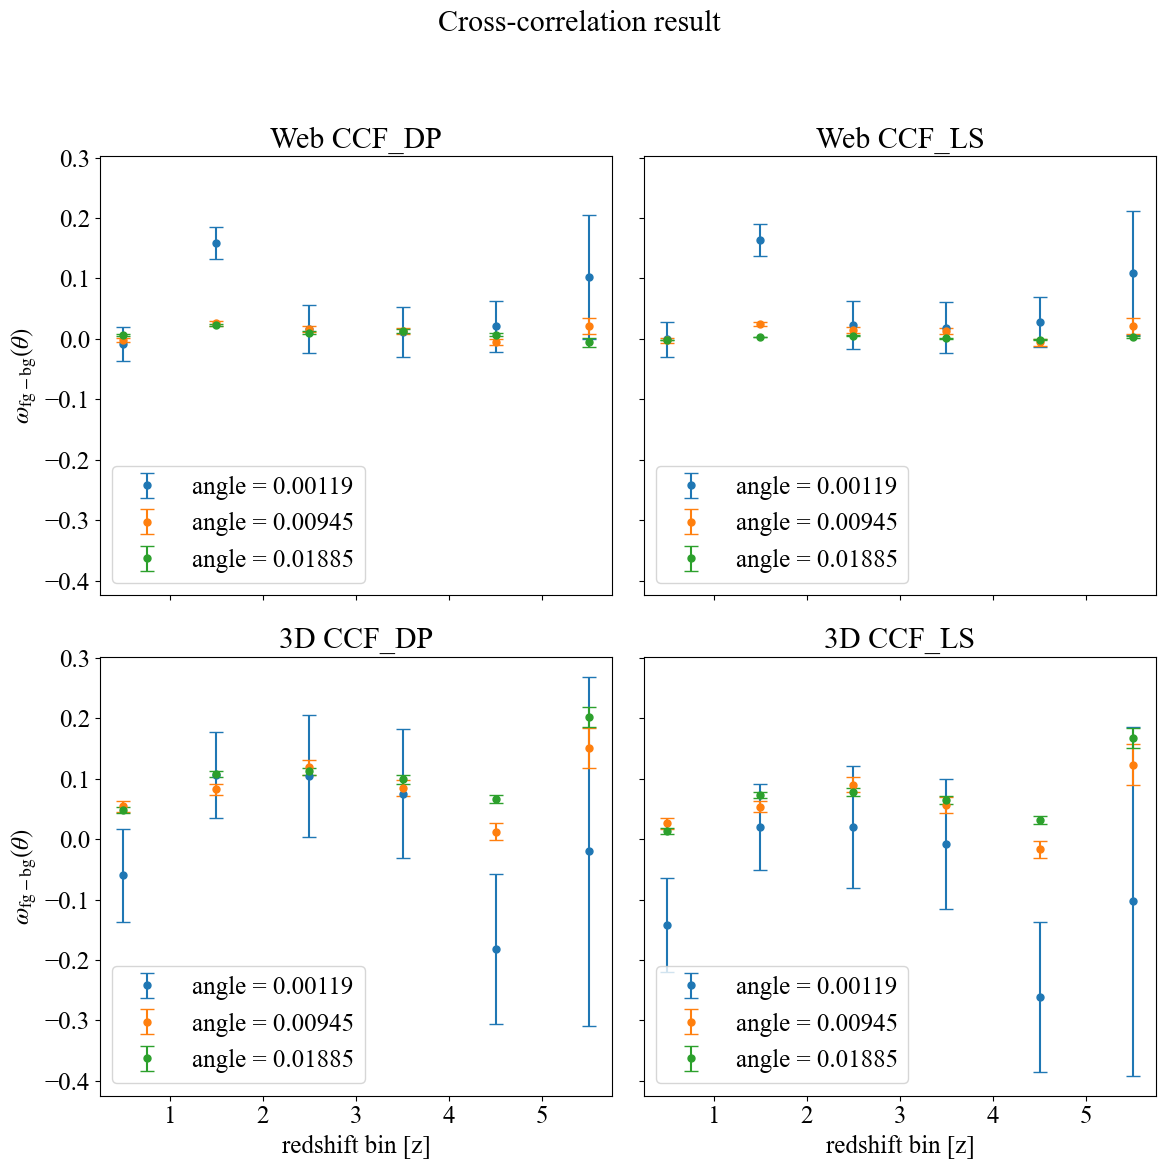

In [46]:

fig, axes = plt.subplots(2, 2, figsize=(12,12), sharey=True)
fig.suptitle(f'Cross-correlation result ')#at angle = {angles[j]:.5f} deg')

axes[0,0].set_title('Web CCF_DP')
#axes[0,0].set_xlabel('redshift bin')
axes[0,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
axes[0,0].errorbar(z_centers, values_web_DP[3],
        yerr=errors_web_DP[3], fmt='.', ms=10,capsize=5, label=f'angle = {angles[3]:.5f}')
axes[0,0].errorbar(z_centers, values_web_DP[6],
        yerr=errors_web_DP[6], fmt='.', ms=10,capsize=5, label=f'angle = {angles[6]:.5f}')
axes[0,0].errorbar(z_centers, values_web_DP[7],
        yerr=errors_web_DP[7], fmt='.', ms=10,capsize=5, label=f'angle = {angles[7]:.5f}')
axes[0,0].tick_params(labelbottom=False)
axes[0,0].legend()
#axes[0,0].grid()

axes[0,1].set_title('Web CCF_LS')
#axes[0,1].set_xlabel('redshift bin')
#axes[0,1].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
axes[0,1].errorbar(z_centers, values_web_tree_LS[3],
        yerr=errors_web_tree_LS[3], fmt='.', ms=10,capsize=5, label=f'angle = {angles[3]:.5f}')
axes[0,1].errorbar(z_centers, values_web_tree_LS[6],
        yerr=errors_web_tree_LS[6], fmt='.', ms=10,capsize=5, label=f'angle = {angles[6]:.5f}')
axes[0,1].errorbar(z_centers, values_web_tree_LS[j],
        yerr=errors_web_tree_LS[j], fmt='.', ms=10,capsize=5, label=f'angle = {angles[7]:.5f}')
#axes[0,1].scatter(z_centers, values_web_DP[j])
axes[0,1].tick_params(labelbottom=False)
axes[0,1].legend()
#axes[0,1].grid()

#     axes[1,0].set_title('3D CCF_LS')
#     axes[1,0].set_xlabel('redshift bin')
#     axes[1,0].errorbar(z_centers, values_3D_LS[j],
#             yerr=errors_3D_LS[j], fmt='.', ms=10,capsize=5, label=angles[7])
#     axes[1,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
#     #axes[1,0].scatter(z_centers, values_web_DP[j])
#     axes[1,0].grid()

axes[1,0].set_title('3D CCF_DP')
axes[1,0].set_xlabel('redshift bin [z]')
axes[1,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
axes[1,0].errorbar(z_centers, values_3D_DP[3],
        yerr=errors_3D_DP[3], fmt='.', ms=10,capsize=5, label=f'angle = {angles[3]:.5f}')
axes[1,0].errorbar(z_centers, values_3D_DP[6],
        yerr=errors_3D_DP[6], fmt='.', ms=10,capsize=5, label=f'angle = {angles[6]:.5f}')
axes[1,0].errorbar(z_centers, values_3D_DP[7],
        yerr=errors_3D_DP[7], fmt='.', ms=10,capsize=5, label=f'angle = {angles[7]:.5f}')
axes[1,0].legend()
#axes[1,0].grid()

axes[1,1].set_title('3D CCF_LS')
axes[1,1].set_xlabel('redshift bin [z]')
#axes[1,1].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
axes[1,1].errorbar(z_centers, values_3D_tree_LS[3],
        yerr=errors_3D_tree_LS[3], fmt='.', ms=10,capsize=5, label=f'angle = {angles[3]:.5f}')
axes[1,1].errorbar(z_centers, values_3D_tree_LS[6],
        yerr=errors_3D_tree_LS[6], fmt='.', ms=10,capsize=5, label=f'angle = {angles[6]:.5f}')
axes[1,1].errorbar(z_centers, values_3D_tree_LS[7],
        yerr=errors_3D_tree_LS[7], fmt='.', ms=10,capsize=5, label=f'angle = {angles[7]:.5f}')
axes[1,1].legend()
#axes[1,1].grid()

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle

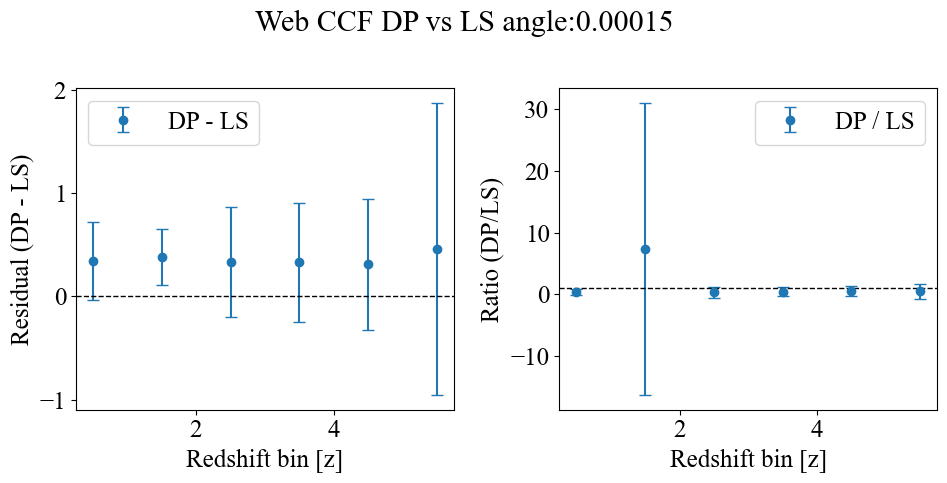

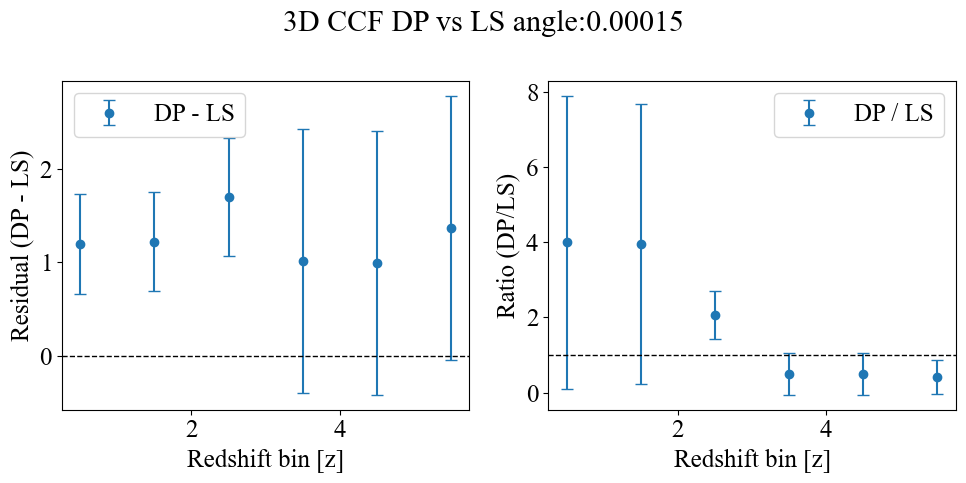

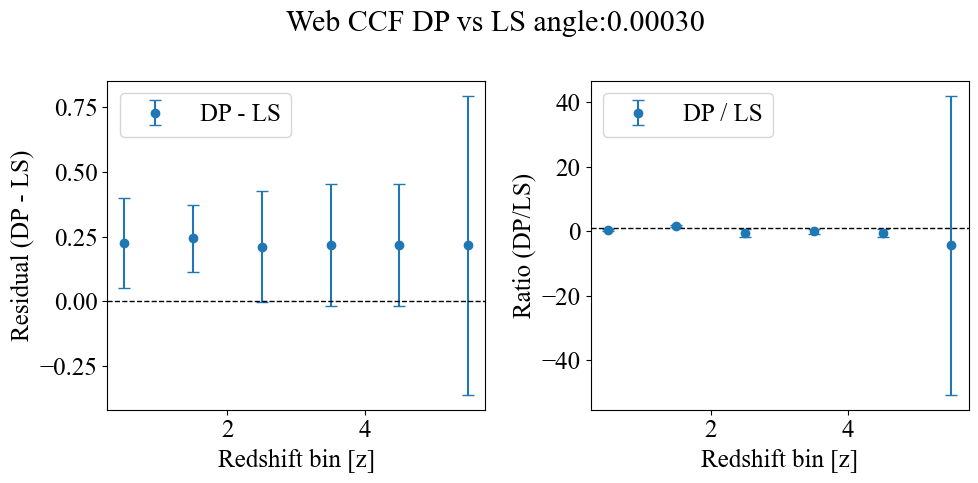

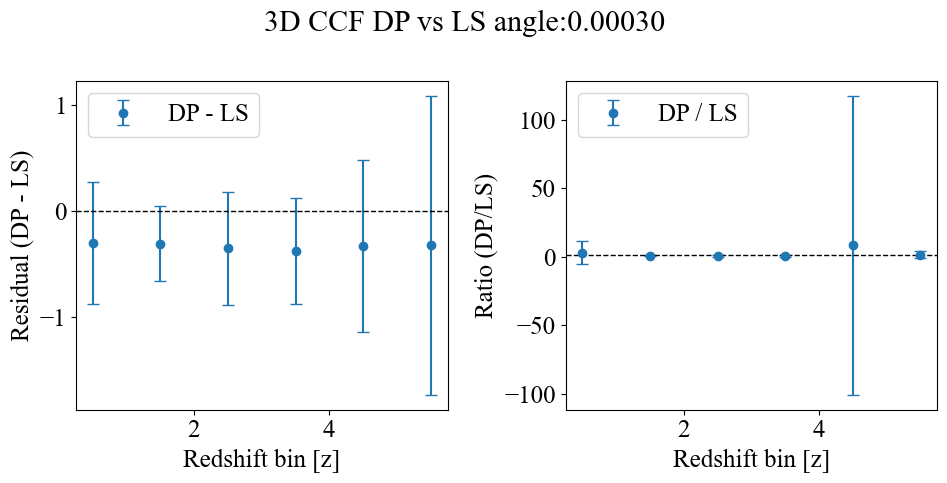

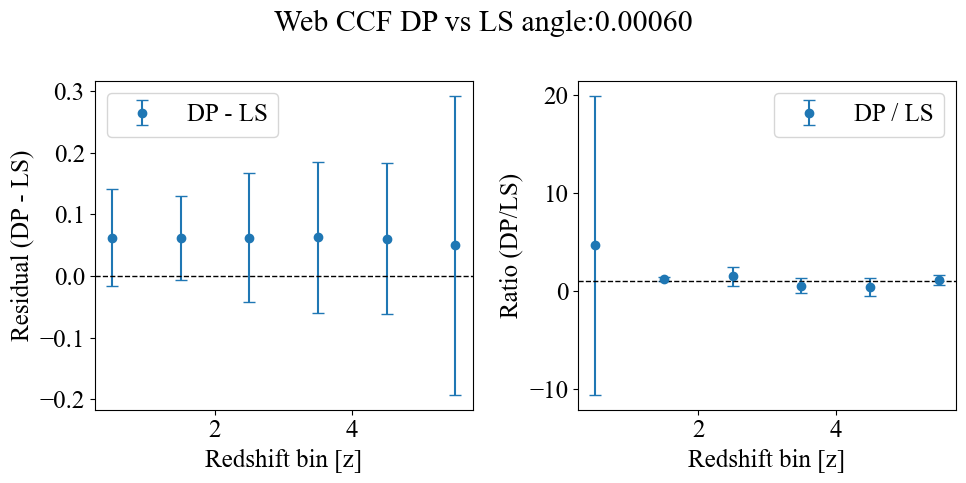

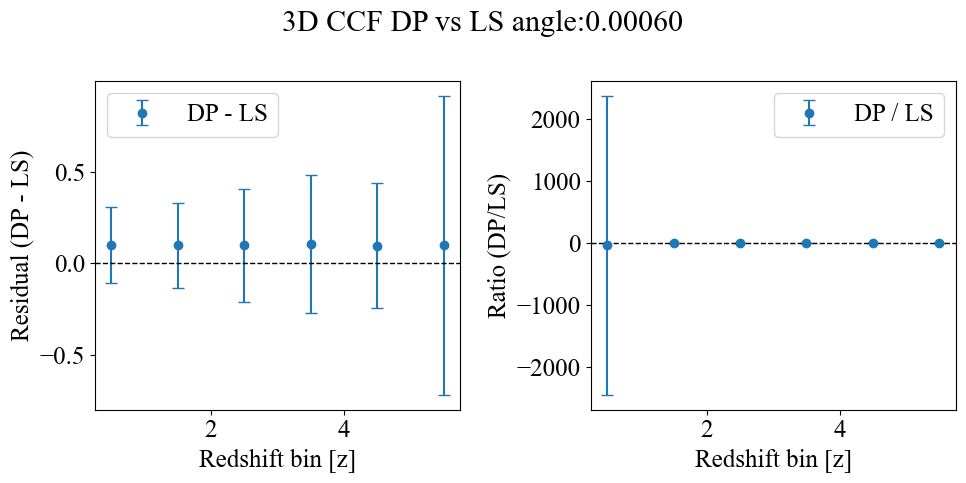

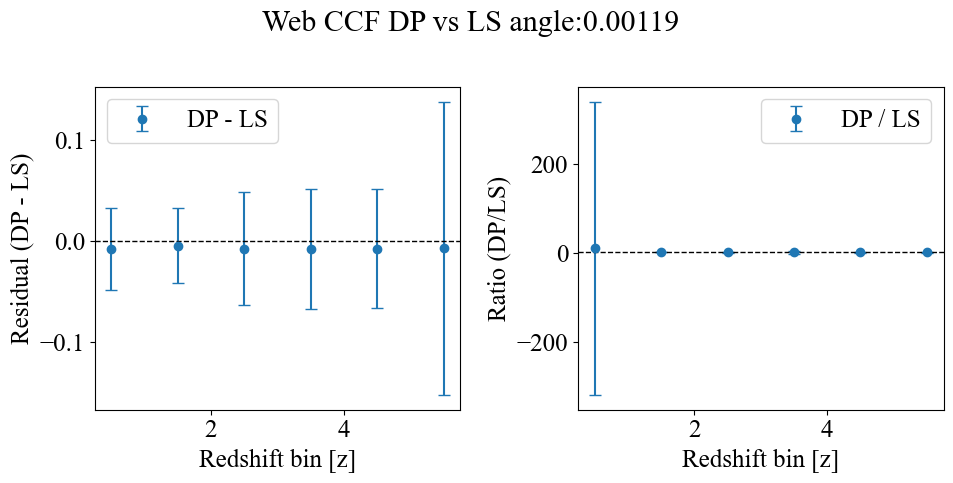

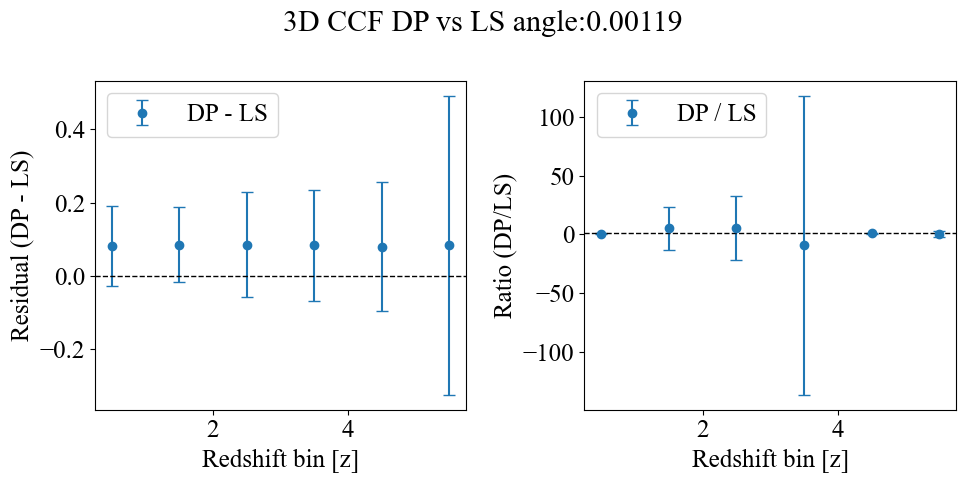

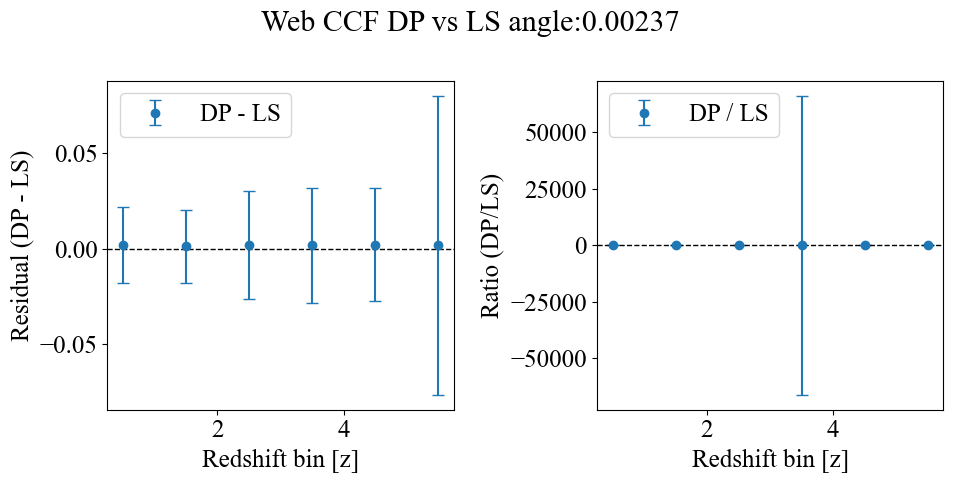

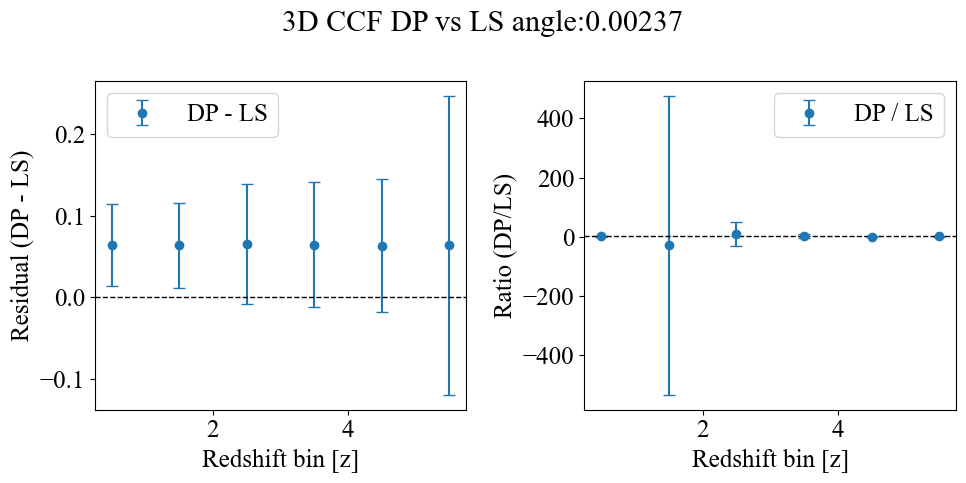

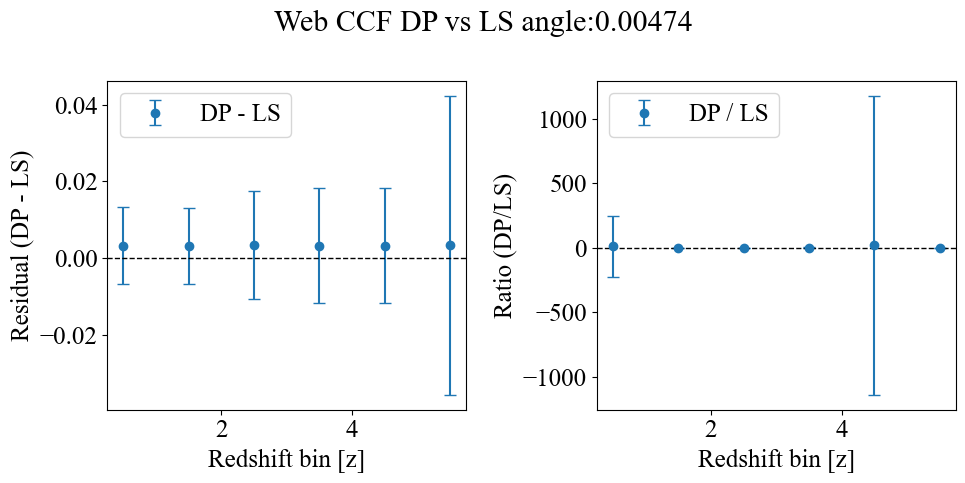

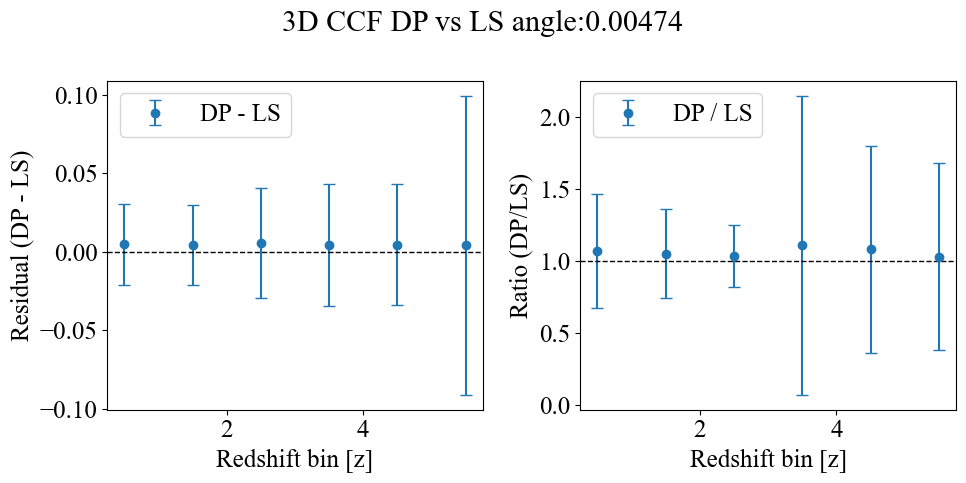

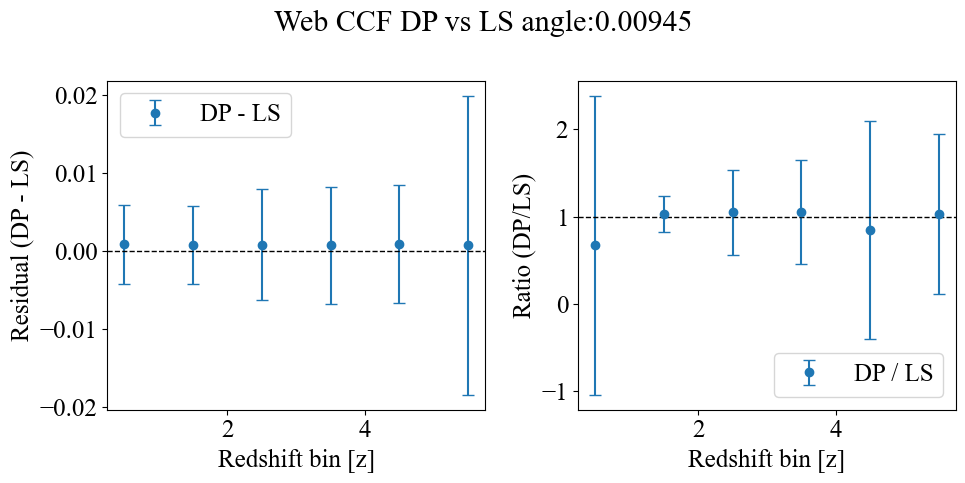

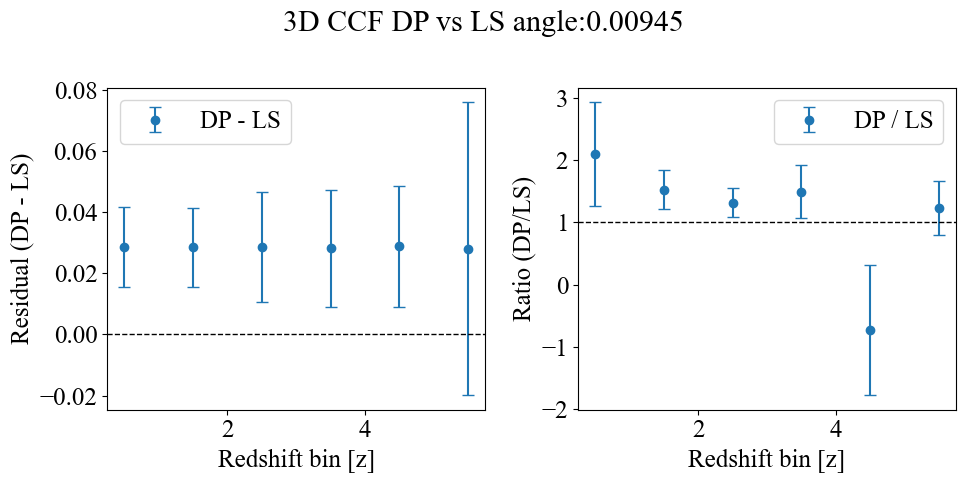

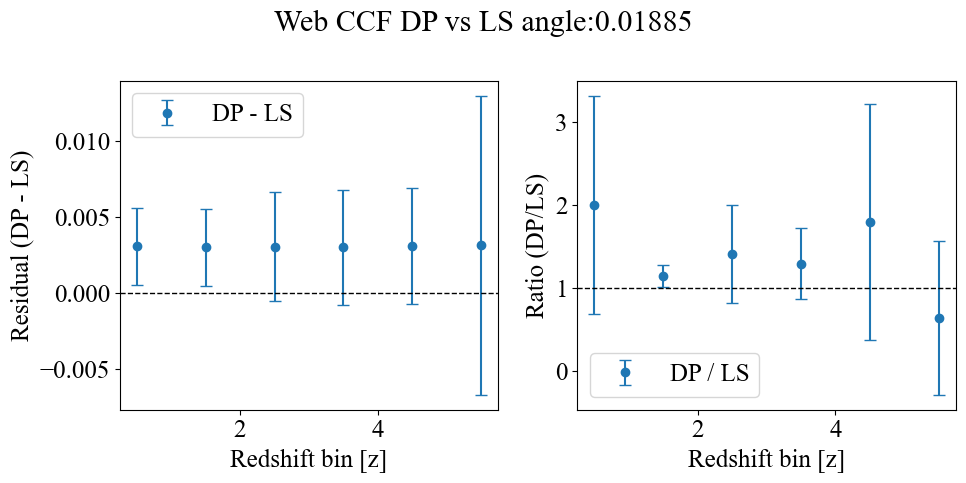

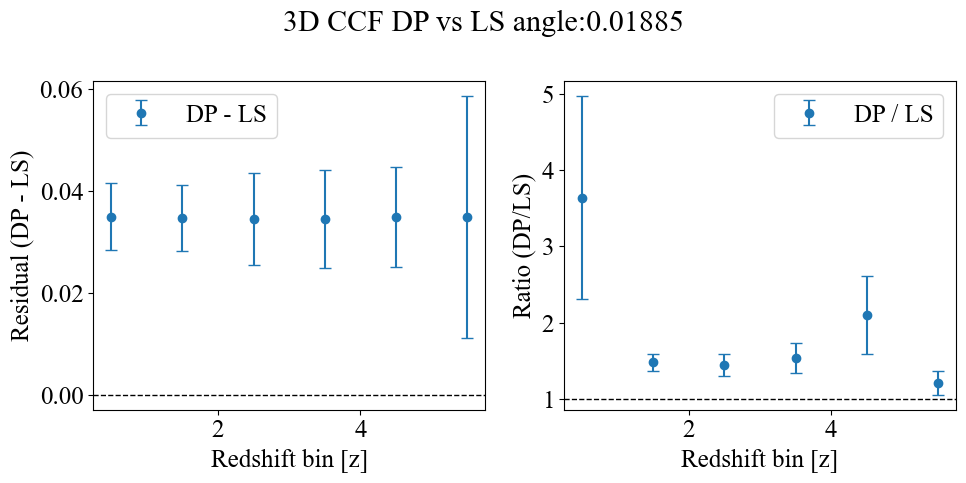

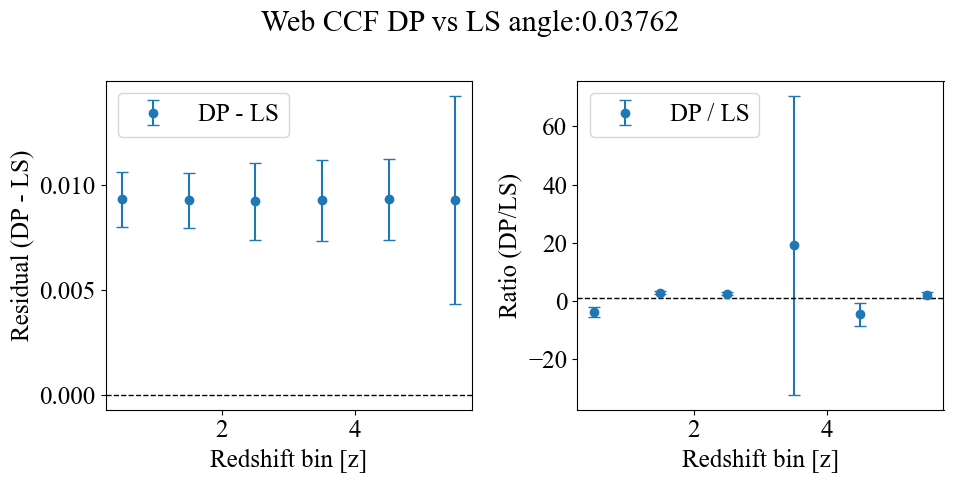

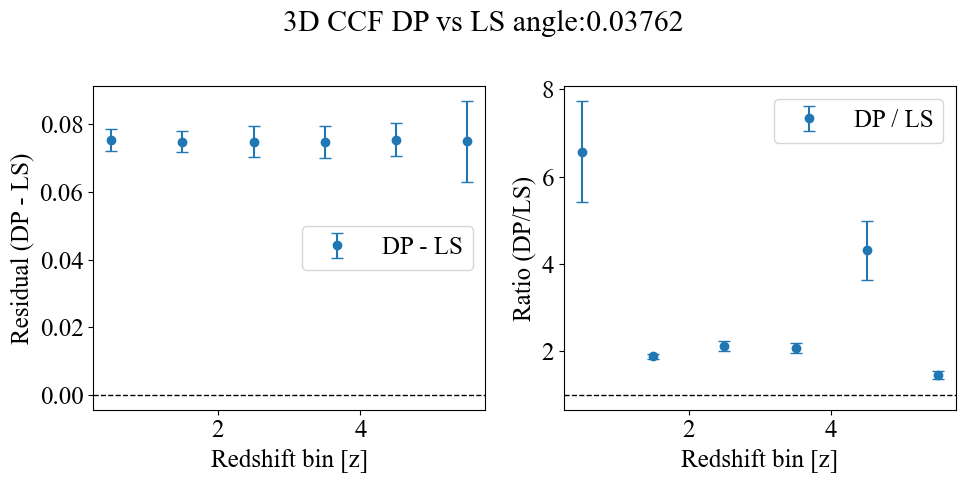

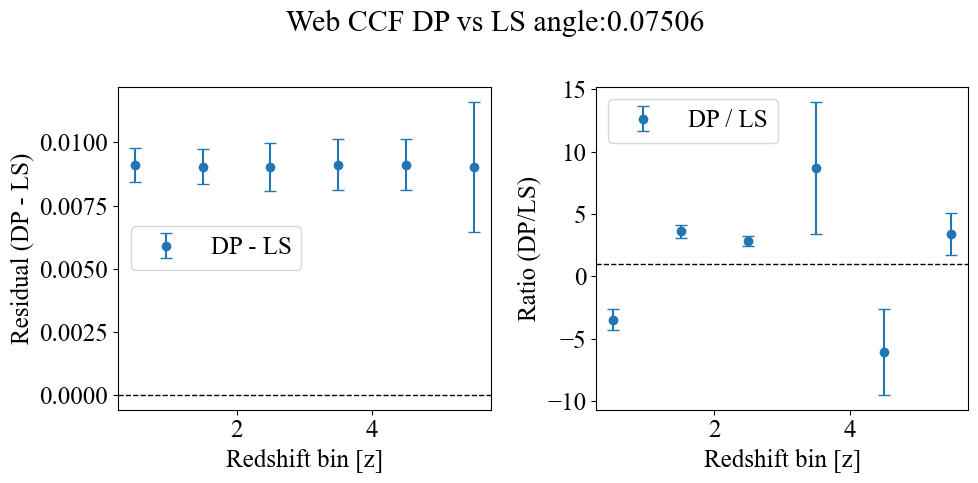

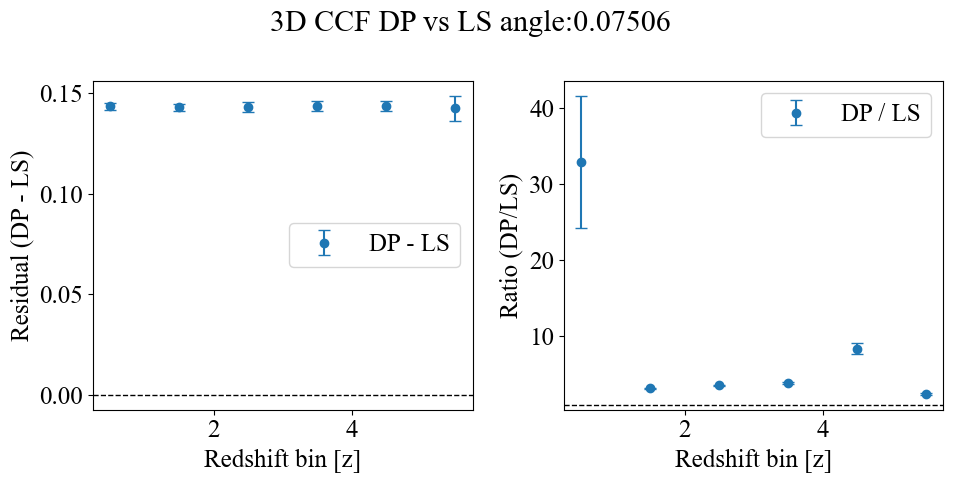

In [26]:
ratio_web_over_z, ratio_err_web_over_z, residual_web_over_z, residual_err_web_over_z = {}, {}, {}, {}
ratio_3d_over_z, ratio_err_3d_over_z, residual_3d_over_z, residual_err_3d_over_z = {}, {}, {}, {}




for i in range(len(values_3D_DP)):
    angle = angles[i]
    
    ratio_web_over_z[angle], ratio_err_web_over_z[angle], residual_web_over_z[angle], residual_err_web_over_z[angle] = ce.compare_estimators_over_redshift(
                                                                                          z_bins=z_centers,
                                                                                          dp_vals=values_web_DP[i],
                                                                                          dp_err=errors_web_DP[i],
                                                                                          ls_vals=values_web_tree_LS[i],
                                                                                          ls_err=errors_web_tree_LS[i],
                                                                                          title=f'Web CCF DP vs LS angle:{angle:.5f}'
                                                                                          )
    ratio_3d_over_z[angle], ratio_err_3d_over_z[angle], residual_3d_over_z[angle], residual_err_3d_over_z[angle] = ce.compare_estimators_over_redshift(
                                                                                          z_bins=z_centers,
                                                                                          dp_vals=values_3D_DP[i],
                                                                                          dp_err=errors_3D_DP[i],
                                                                                          ls_vals=values_3D_tree_LS[i],
                                                                                          ls_err=errors_3D_tree_LS[i],
                                                                                          title=f'3D CCF DP vs LS angle:{angle:.5f}'
                                                                                          )

In [48]:
# --- helper: compress for each theta-array (you already have this) ---
def compress_theta_mean(wtheta, theta_centers, theta_min=None, theta_max=None):
    th = np.asarray(theta_centers)
    w = np.asarray(wtheta)
    mask = np.ones_like(th, dtype=bool)
    if theta_min is not None: mask &= (th >= theta_min)
    if theta_max is not None: mask &= (th <= theta_max)
    vals = w[mask]
    if len(vals) == 0:
        return np.mean(w)  # fallback
    return np.mean(vals)

# --- safer clustering_nz that accepts arrays and guards against invalid denominators ---
def clustering_nz_array(wsp_arr, wss_arr, wpp_arr, dz=1.0, eps=1e-15, floor_negative=True):
    wsp = np.asarray(wsp_arr, dtype=float)
    wss = np.asarray(wss_arr, dtype=float)
    wpp = np.asarray(wpp_arr, dtype=float)
    dz = np.asarray(dz)
    if dz.ndim == 0:
        dz = np.full(wsp.shape, float(dz))

    # compute denominator but avoid sqrt of negative
    prod = wss * wpp
    # mark invalid where product <= 0 or any is not finite
    invalid = (~np.isfinite(wsp)) | (~np.isfinite(wss)) | (~np.isfinite(wpp)) | (prod <= 0)

    denom = np.sqrt(np.maximum(prod, 0.0)) + eps
    raw = wsp / (dz * denom)

    # set invalid or non-finite raw to zero (you can choose other behaviour)
    raw = np.where(invalid, 0.0, raw)
    raw = np.where(np.isfinite(raw), raw, 0.0)

    # optionally floor small/negative raws to zero if you want non-negative n(z)
    if floor_negative:
        raw = np.where(raw > 0, raw, 0.0)

    norm = np.sum(raw * dz)
    if norm <= 0:
        # nothing positive: return zeros and let caller inspect raw
        nz = np.zeros_like(raw)
    else:
        nz = raw / norm

    return nz, raw


In [49]:
theta_edges = np.logspace(-4, -1, 11)      # 10 bins
theta_centers = np.sqrt(theta_edges[:-1] * theta_edges[1:])  # geometric mean
#print(theta_centers)

def jackknife_indices(Nobj, Njack):
    """Assign each object an index from 0..Njack-1 for jackknife regions."""
    idx = np.arange(Nobj)
    np.random.shuffle(idx)
    bins = np.array_split(idx, Njack)
    labels = np.zeros(Nobj, dtype=int)
    for i, b in enumerate(bins):
        labels[b] = i
    return labels

import sys

def logging(msg):
    sys.stdout.write(f"\r{msg}")
    sys.stdout.flush()

def jackknife_nz(cosmos, randoms, reference_bins, z_bins=z_bins,
                 min_bin=min_bin, max_bin=max_bin, bins=bins, bin_type=bin_type,
                 theta_centers=theta_centers, Njack=20, dz=1.0):
    """
    Jackknife error estimation for clustering n(z).

    cosmos : dict with 'SkyCoord' (photometric sample)
    randoms : SkyCoord (random catalog for photo)
    reference_bins : dict {z_bin: SkyCoord} (spectroscopic reference per bin)
    z_bins : list of str
    """
    # Assign jackknife regions
    Nobj = len(cosmos)
    labels = jackknife_indices(Nobj, Njack)

    nz_jacks = []

    for i in range(Njack):
        logging(f"Jackknife {i+1}/{Njack}")

        # Remove one region
        mask = labels != i
        cosmos_jack = cosmos[mask]

        # --- recompute correlation functions ---
        # ACF of photo sample
        Omega_pp, _, _ = hsc.Landy_Szalay_estimator(
            cosmos_jack, randoms,
            min_bin=min_bin, max_bin=max_bin,
            bins=bins, type=bin_type)

        wpp_val = compress_theta_mean(Omega_pp, theta_centers)
        wpp_arr = np.full(len(z_bins), wpp_val)

        wsp_arr, wss_arr = [], []
        for z in z_bins:
            # Cross photo x reference(z)
            Omega_ps, _, _ = hsc.Landy_Szalay_estimator_cross(
                cosmos_jack, reference_bins[z]['SkyCoord'],
                randoms, randoms,
                min_bin=min_bin, max_bin=max_bin,
                bins=bins, type=bin_type)
            wsp_arr.append(compress_theta_mean(Omega_ps, theta_centers))

            # Reference auto-corr (can be precomputed once if not jackknifed)
            Omega_ss, _, _ = hsc.Landy_Szalay_estimator(
                reference_bins[z]['SkyCoord'], randoms,
                min_bin=min_bin, max_bin=max_bin,
                bins=bins, type=bin_type)
            wss_arr.append(compress_theta_mean(Omega_ss, theta_centers))

        wsp_arr = np.array(wsp_arr)
        wss_arr = np.array(wss_arr)

        nz, _ = clustering_nz_array(wsp_arr, wss_arr, wpp_arr, dz)
        nz_jacks.append(nz)

    # Convert to array
    nz_jacks = np.array(nz_jacks)

    # --- covariance & errors ---
    nz_mean = np.mean(nz_jacks, axis=0)
    diffs = nz_jacks - nz_mean
    cov = (Njack - 1)/Njack * diffs.T @ diffs
    nz_err = np.sqrt(np.diag(cov))

    return nz_mean, nz_err, cov

# def jackknife_nz_tree(cosmos, randoms_data, reference_bins, randoms_ref, 
#                       z_bins=z_bins, min_bin=min_bin, max_bin=max_bin,
#                       bins=bins, bin_type=bin_type, theta_centers=theta_centers, 
#                       Njack=20, dz=1.0, estimator_type='Natural'):
#     """
#     Jackknife error estimation for clustering n(z).

#     Parameters
#     ----------
#     cosmos : dict with 'SkyCoord' (photometric sample)
#     randoms_data : SkyCoord (random catalog for photometric sample)
#     reference_bins : dict {z_bin: {'SkyCoord': spectroscopic reference sample}}
#     randoms_ref : SkyCoord (random catalog for spectroscopic reference)
#     z_bins : list of str
#     """
#     # Assign jackknife regions
#     Nobj = len(cosmos)
#     labels = jackknife_indices(Nobj, Njack)

#     nz_jacks = []

#     for i in range(Njack):
#         logging(f"Jackknife {i+1}/{Njack}")

#         # Remove one region
#         mask = labels != i
#         cosmos_jack = cosmos[mask]

#         # --- recompute correlation functions ---
#         # ACF of photo sample
#         Omega_pp, _, _ = LS_BallTree.Landy_Szalay_estimator_tree(
#             cosmos_jack, randoms_data,
#             min_bin=min_bin, max_bin=max_bin,
#             bins=bins, type=bin_type, estimator_type=estimator_type)

#         wpp_val = compress_theta_mean(Omega_pp, theta_centers)
#         wpp_arr = np.full(len(z_bins), wpp_val)

#         wsp_arr, wss_arr = [], []
#         for z in z_bins:
#             # Cross photo x reference(z)
#             Omega_ps, _, _ = LS_BallTree.Landy_Szalay_estimator_cross_tree(
#                 cosmos_jack, reference_bins[z]['SkyCoord'],
#                 randoms_data, randoms_ref,
#                 min_bin=min_bin, max_bin=max_bin,
#                 bins=bins, type=bin_type)
#             wsp_arr.append(compress_theta_mean(Omega_ps, theta_centers))

#             # Reference auto-corr (can be precomputed once if not jackknifed)
#             Omega_ss, _, _ = LS_BallTree.Landy_Szalay_estimator_tree(
#                 reference_bins[z]['SkyCoord'], randoms_ref,
#                 min_bin=min_bin, max_bin=max_bin,
#                 bins=bins, type=bin_type, estimator_type=estimator_type)
#             wss_arr.append(compress_theta_mean(Omega_ss, theta_centers))

#         wsp_arr = np.array(wsp_arr)
#         wss_arr = np.array(wss_arr)

#         nz, _ = clustering_nz_array(wsp_arr, wss_arr, wpp_arr, dz)
#         nz_jacks.append(nz)

#     # Convert to array
#     nz_jacks = np.array(nz_jacks)

#     # --- covariance & errors ---
#     nz_mean = np.mean(nz_jacks, axis=0)
#     diffs = nz_jacks - nz_mean
#     cov = (Njack - 1)/Njack * diffs.T @ diffs
#     nz_err = np.sqrt(np.diag(cov))

#     return nz_mean, nz_err, cov

def jackknife_nz_tree(cosmos, randoms_data, reference_bins, randoms_ref, 
                      z_bins=z_bins, min_bin=min_bin, max_bin=max_bin,
                      bins=bins, bin_type=bin_type, theta_centers=theta_centers, 
                      Njack=20, dz=1.0, estimator_type='Natural'):
    """
    Jackknife error estimation for clustering n(z), re-using wss (computed once).

    cosmos : SkyCoord photometric sample
    randoms_data : SkyCoord randoms for photo
    reference_bins : dict {z_bin: {'SkyCoord': reference sample}}
    randoms_ref : SkyCoord randoms for reference
    """

    # --------- PRECOMPUTE w_ss ONCE (NOT JACKKNIFED) ---------
    pre_wss = {}
    for z in z_bins:
        Omega_ss, _, _ = LS_BallTree.Landy_Szalay_estimator_tree(
            reference_bins[z]['SkyCoord'], randoms_ref,
            min_bin=min_bin, max_bin=max_bin,
            bins=bins, type=bin_type, estimator_type=estimator_type)
        pre_wss[z] = compress_theta_mean(Omega_ss, theta_centers)

    # --------- ASSIGN JACKKNIFE LABELS ---------
    Nobj = len(cosmos)
    labels = jackknife_indices(Nobj, Njack)

    nz_jacks = []

    # --------- LOOP OVER JACKKNIFE SUBSAMPLES ---------
    for i in range(Njack):
        logging(f"Jackknife {i+1}/{Njack}")

        mask = labels != i
        cosmos_jack = cosmos[mask]

        # photo auto
        Omega_pp, _, _ = LS_BallTree.Landy_Szalay_estimator_tree(
            cosmos_jack, randoms_data,
            min_bin=min_bin, max_bin=max_bin,
            bins=bins, type=bin_type, estimator_type=estimator_type)

        wpp_val = compress_theta_mean(Omega_pp, theta_centers)
        wpp_arr = np.full(len(z_bins), wpp_val)

        wsp_arr = []
        wss_arr = []

        for z in z_bins:
            # photo x reference cross
            Omega_ps, _, _ = LS_BallTree.Landy_Szalay_estimator_cross_tree(
                cosmos_jack, reference_bins[z]['SkyCoord'],
                randoms_data, randoms_ref,
                min_bin=min_bin, max_bin=max_bin,
                bins=bins, type=bin_type)

            wsp_arr.append(compress_theta_mean(Omega_ps, theta_centers))
            wss_arr.append(pre_wss[z])  # <-- REUSE PRECOMPUTED

        wsp_arr = np.array(wsp_arr)
        wss_arr = np.array(wss_arr)

        nz, _ = clustering_nz_array(wsp_arr, wss_arr, wpp_arr, dz)
        nz_jacks.append(nz)

    # --------- STACK & COMPUTE JACKKNIFE COVARIANCE ---------
    nz_jacks = np.array(nz_jacks)
    nz_mean = np.mean(nz_jacks, axis=0)
    diffs = nz_jacks - nz_mean
    cov = (Njack - 1)/Njack * diffs.T @ diffs
    nz_err = np.sqrt(np.diag(cov))

    return nz_mean, nz_err, cov

In [50]:
ref_small_all = {}
ref_small_all['SkyCoord'] = np.concatenate([ref_bins_small[z]['SkyCoord'] for z in z_bins])

In [51]:
cosmos_web_bins = {}

for z in z_bins:
    print(float(z[:3])+0.2,float(z[4:])-0.2)
    Web_unkn = df_ref[(df_ref['redshifts'] >= float(z[:3])+0.2) & (df_ref['redshifts'] < float(z[4:])-0.2)].sample(n = 1000, random_state=42)  

    cosmos_web_bins[z] = {
        'SkyCoord': SkyCoord(Web_unkn['ra'], Web_unkn['dec'], unit=(u.deg, u.deg), frame='icrs')
    }  

0.2 0.8
1.2 1.8
2.2 2.8
3.2 3.8
4.2 4.8
5.2 5.8


In [52]:
def load_saved_data_csv(name):
    df = pd.read_csv(name)
    return df['mean'], df['error']


In [53]:
nz_mean_3d_tree_20, nz_err_3d_tree_20 = load_saved_data_csv('jackknife_results/20.csv')
nz_mean_3d_tree_30, nz_err_3d_tree_30 = load_saved_data_csv('jackknife_results/30.csv')
nz_mean_3d_tree_40, nz_err_3d_tree_40 = load_saved_data_csv('jackknife_results/40.csv')
nz_mean_3d_tree_80, nz_err_3d_tree_80 = load_saved_data_csv('jackknife_results/80.csv')
nz_mean_3d_tree_90, nz_err_3d_tree_90 = load_saved_data_csv('jackknife_results/90.csv')
nz_mean_3d_tree_100, nz_err_3d_tree_100 = load_saved_data_csv('jackknife_results/100.csv')
nz_mean_web_tree_100, nz_err_web_tree_100 = load_saved_data_csv('jackknife_results/web_100.csv')

Text(0.5, 1.0, 'Jackknife clustering n(z) from fake Web unknowns with z:1.0-2.0 ')

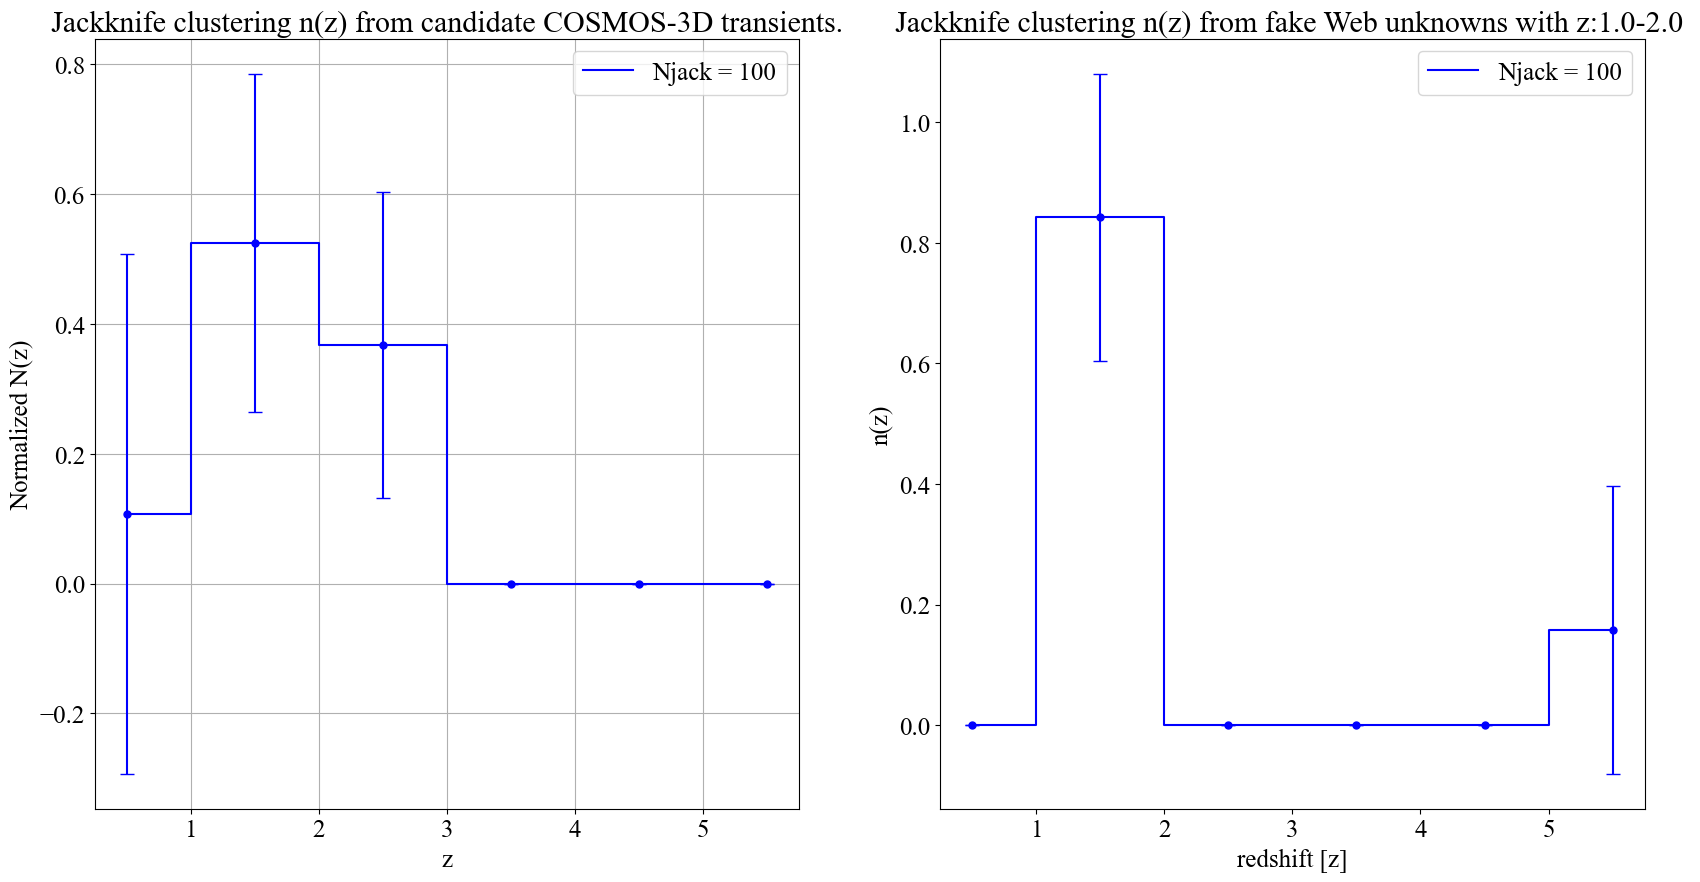

In [54]:
plt.figure(figsize=(20,10))
inferred_z = df_Cos_3D['Host_z']
#plt.title('Jackknife clustering n(z)')
# Define bins from 0 to 6 in steps of 1
bins = np.arange(0, 7, 1)   # gives [0,1,2,3,4,5,6]


plt.subplot(1,2,1)
# plt.title('3D Jackknife  n(z) compared to inferred n(z) from candidate host galaxies.')
plt.title('Jackknife clustering n(z) from candidate COSMOS-3D transients.')
# plt.errorbar(z_centers, nz_mean_3d_tree_80, yerr=nz_err_3d_tree_80, fmt='.', ms=10, capsize=5,color='orange')
# plt.step(z_centers, nz_mean_3d_tree_80, where='mid', label='Njack = 80', color='orange')

# plt.errorbar(z_centers, nz_mean_3d_tree_90, yerr=nz_err_3d_tree_90, fmt='.', ms=10, capsize=5, color='red')
# plt.step(z_centers, nz_mean_3d_tree_90, where='mid', label='Njack = 90', color='red')

plt.errorbar(z_centers, nz_mean_3d_tree_100, yerr=nz_err_3d_tree_100, fmt='.', ms=10, capsize=5, color='blue')
plt.step(z_centers, nz_mean_3d_tree_100, where='mid', label='Njack = 100', color='blue')
#plt.ylim(-0.3,1.0)

# plt.hist(inferred_z, bins=bins, density=True, alpha=0.7, edgecolor='black', label='inferred n(z)')


# plt.xticks(bins)  # ticks at bin edges

plt.xlabel('z')
plt.ylabel('Normalized N(z)')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.errorbar(z_centers, nz_mean_web_tree_100, yerr=nz_err_web_tree_100, fmt='.', ms=10, capsize=5, color='blue')
plt.step(z_centers, nz_mean_web_tree_100, where='mid', label='Njack = 100', color='blue')
plt.xlabel('redshift [z]')
plt.ylabel('n(z)')
plt.legend()
plt.title('Jackknife clustering n(z) from fake Web unknowns with z:1.0-2.0 ')

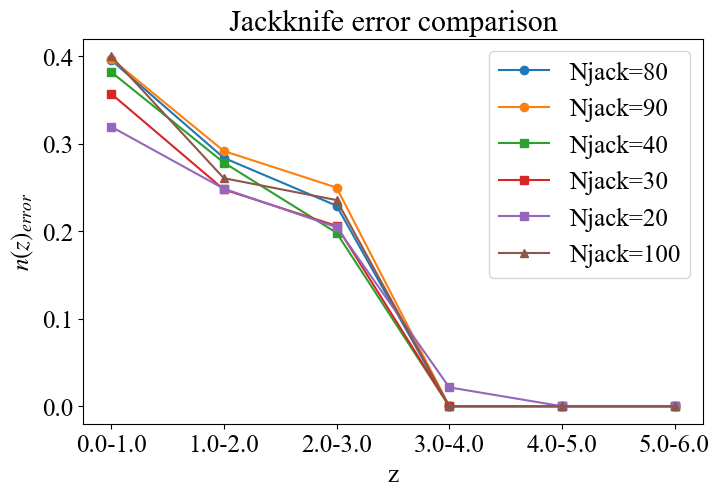

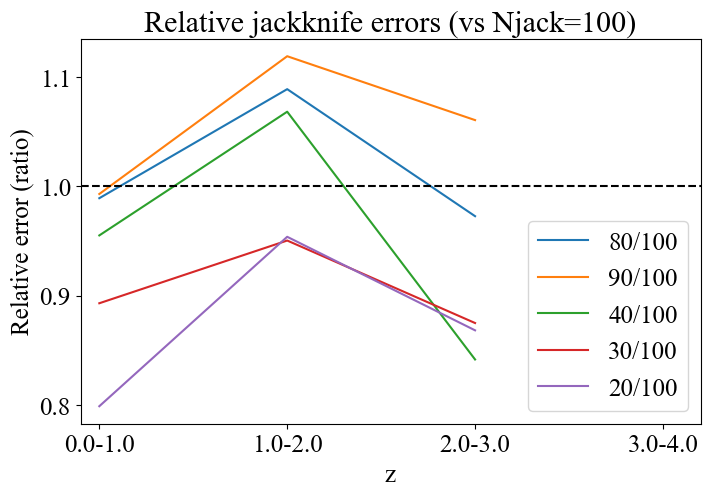

Mean jackknife errors: {20: np.float64(0.13238519974688914), 30: np.float64(0.13519005075086638), 40: np.float64(0.14314479748866213), 80: np.float64(0.1514667730600969), 90: np.float64(0.15648769722253655), 100: np.float64(0.14938816449849004)}
Fractional difference (80 vs 100): 0   -0.010789
1    0.089053
2   -0.027261
3         NaN
4         NaN
5         NaN
Name: error, dtype: float64


In [55]:
# --- 1. Direct comparison of error amplitudes ---
plt.figure(figsize=(8,5))
plt.plot(z_bins, nz_err_3d_tree_80, '-o', label='Njack=80')
plt.plot(z_bins, nz_err_3d_tree_90, '-o', label='Njack=90')
plt.plot(z_bins, nz_err_3d_tree_40, '-s', label='Njack=40')
plt.plot(z_bins, nz_err_3d_tree_30, '-s', label='Njack=30')
plt.plot(z_bins, nz_err_3d_tree_20, '-s', label='Njack=20')

plt.plot(z_bins, nz_err_3d_tree_100, '^-', label='Njack=100')


plt.xlabel("z")
plt.ylabel(r'$n(z)_{error}$')
plt.legend()
plt.title("Jackknife error comparison")
plt.show()

# --- 2. Ratios relative to Njack=100 ---
plt.figure(figsize=(8,5))
plt.plot(z_bins, nz_err_3d_tree_80/nz_err_3d_tree_100, '-', label='80/100')
plt.plot(z_bins, nz_err_3d_tree_90/nz_err_3d_tree_100, '-', label='90/100')
plt.plot(z_bins, nz_err_3d_tree_40/nz_err_3d_tree_100, '-', label='40/100')
plt.plot(z_bins, nz_err_3d_tree_30/nz_err_3d_tree_100, '-', label='30/100')
plt.plot(z_bins, nz_err_3d_tree_20/nz_err_3d_tree_100, '-', label='20/100')
plt.axhline(1.0, color='k', linestyle='--')
plt.xlim(-0.1,3.2)
plt.xlabel("z")
plt.ylabel("Relative error (ratio)")
plt.legend()
plt.title("Relative jackknife errors (vs Njack=100)")
plt.show()

# --- 3. Summaries ---
mean_err = {

    20: np.mean(nz_err_3d_tree_20),
    30: np.mean(nz_err_3d_tree_30),
    40: np.mean(nz_err_3d_tree_40),
    80: np.mean(nz_err_3d_tree_80),
    90: np.mean(nz_err_3d_tree_90),
    100: np.mean(nz_err_3d_tree_100)
}
print("Mean jackknife errors:", mean_err)

spread = (nz_err_3d_tree_80 - nz_err_3d_tree_100)/nz_err_3d_tree_100
print("Fractional difference (80 vs 100):", spread)


In [56]:
import pandas as pd

# Suppose you have dictionaries of errors like:
errors = {20: nz_err_3d_tree_20, 30: nz_err_3d_tree_30, 40: nz_err_3d_tree_40, 80: nz_err_3d_tree_80, 90: nz_err_3d_tree_90, 100: nz_err_3d_tree_100}
# and all err arrays are same length

ref = errors[100]
summary = {}

for nj, err in errors.items():
    # Mask invalid bins (where ref or err is zero or nan)
    mask = (ref != 0) & (err != 0) & ~np.isnan(ref) & ~np.isnan(err)
    
    # Compute fractional difference only for valid bins
    frac_diff = np.full_like(ref, np.nan, dtype=float)
    frac_diff[mask] = (err[mask] - ref[mask]) / ref[mask]
    
    # Store summary stats
    summary[nj] = {
        'mean_frac_diff': np.nanmean(frac_diff),
        'std_frac_diff': np.nanstd(frac_diff),
        'n_valid_bins': np.sum(mask)
    }

summary_df = pd.DataFrame(summary).T
print(summary_df)

     mean_frac_diff  std_frac_diff  n_valid_bins
20        -0.126389       0.063447           3.0
30        -0.093874       0.032198           3.0
40        -0.044978       0.092618           3.0
80         0.017001       0.051390           3.0
90         0.057657       0.051543           3.0
100        0.000000       0.000000           3.0


In [57]:
prnt()

NameError: name 'prnt' is not defined

In [58]:
nz_mean_web_tree, nz_err_web_tree, cov_web_tree = {}, {}, {}
nz_mean_3d_tree, nz_err_3d_tree, cov_3d_tree = [], [] ,[]





In [59]:
nz_mean_3d, nz_err_3d, cov_3d = [], [] ,[]
nz_mean_web, nz_err_web, cov_web = [], [], []

In [60]:
# nz_mean_3d, nz_err_3d, cov_3d = jackknife_nz(
#                                         cosmos=cosmos_3D['SkyCoord'],
#                                         randoms=random_web3d['SkyCoord'],
#                                         reference_bins=ref_bins_small,
#                                         #randoms_ref=random_ref['SkyCoord'],
#                                         Njack=80
#                                         )



In [61]:
# nz_mean_web, nz_err_web, cov_web = jackknife_nz(
#                                         cosmos=cosmos_web['SkyCoord'],
#                                         randoms=random_web3d['SkyCoord'],
#                                         reference_bins=ref_bins_small,
#                                         #randoms_ref=random_ref['SkyCoord'],
#                                         Njack=80
#                                         )

# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plt.errorbar(z_centers, nz_mean_3d, yerr=nz_err_3d, fmt='.', ms=10, capsize=5)
# plt.step(z_centers, nz_mean_3d, where='mid', label='clustering n(z)', color='blue')
# plt.xlabel('redshift [z]')
# plt.ylabel('n(z)')
# plt.title('3D Jackknife clustering n(z)')
# plt.subplot(1,2,2)
# plt.errorbar(z_centers, nz_mean_web, yerr=nz_err_web, fmt='.', ms=10, capsize=5)
# plt.step(z_centers, nz_mean_web, where='mid', label='clustering n(z)', color='blue')
# plt.xlabel('redshift [z]')
# plt.ylabel('n(z)')
# plt.title('fake Web unknowns with z:1.2-1.7 Jackknife clustering n(z)')

In [62]:
df_Cos_3D

,Confidence,Link,RA,Dec,Host_ID,Host_RA,Host_Dec,Host_sep,Host_z,Host_z_final,needs_further_inspection,Christa_Comment
0,2,https://www.stsci.edu/~tsst/c3d/o001_t001_0_co...,149.759004,2.133165,216141,149.758999,2.133157,0.032,2.203,-99.000,yes,hostless? Weird shape
1,3,https://www.stsci.edu/~tsst/c3d/o001_t001_0_co...,149.767877,2.119591,214949,149.767867,2.119588,0.038,1.340,-99.000,yes,seems real? Or something weird going on with s...
2,3,https://www.stsci.edu/~tsst/c3d/o001_t001_0_co...,149.782602,2.095719,212206,149.782602,2.095726,0.025,1.350,-99.000,yes,seems like something weird going on with subtr...
3,2,https://www.stsci.edu/~tsst/c3d/o004_t004_3_co...,150.234389,1.886099,326840,150.234485,1.886024,0.441,0.006,0.006,yes,maybe real?
4,2,https://www.stsci.edu/~tsst/c3d/o004_t004_3_co...,150.258403,1.938228,334460,150.258400,1.938082,0.526,0.679,-99.000,yes,maybe real?
...,...,...,...,...,...,...,...,...,...,...,...,...
137,2,https://www.stsci.edu/~tsst/c3d/o016_t016_2_co...,150.345925,2.261992,726201,150.345927,2.261987,0.018,1.768,1.768,yes,seems real; nuclear transient?
138,1,https://www.stsci.edu/~tsst/c3d/o016_t016_3_co...,150.373547,2.224541,763665,150.373569,2.224527,0.095,0.979,0.979,NaN,real
139,1,https://www.stsci.edu/~tsst/c3d/o016_t016_3_co...,150.389550,2.255718,767926,150.389512,2.255856,0.517,1.310,-99.000,NaN,real
140,1,https://www.stsci.edu/~tsst/c3d/o016_t016_3_co...,150.370572,2.189248,779047,150.370581,2.189255,0.042,0.730,0.730,NaN,real


In [63]:
df_Cos_3D['Link'] = df_Cos_3D['Link'].apply(lambda x: f"\\href{{{x}}}{{link}}")
latex_table = df_Cos_3D.to_latex(index=False, escape=False, longtable=True)

# Write to a .tex file (optional)
with open("table.tex", "w") as f:
    f.write(latex_table)

In [64]:
for hostsep in df_Cos_3D['Host_sep']:
    if hostsep > 1.5:
        print(hostsep)

1.64
1.842
1.893


In [65]:
min_bin_2 = 1e-4 * u.deg
max_bin_2 = 0.5e-1 * u.deg
bins_2 = 5
theta_edges_2 = np.logspace(-4, -0.5, 6)      # 6 bins
theta_centers_2 = np.sqrt(theta_edges_2[:-1] * theta_edges_2[1:])  # geometric mean
#print(theta_centers)


nz_mean_web_tree['1.0-2.0'], nz_err_web_tree['1.0-2.0'], cov_web_tree['1.0-2.0'] = jackknife_nz_tree(
                                                                                    cosmos=cosmos_web['SkyCoord'],
                                                                                    randoms_data=random_web3d['SkyCoord'],
                                                                                    reference_bins=ref_bins_small,
                                                                                    randoms_ref=random_ref['SkyCoord'],
                                                                                    min_bin=min_bin_2, 
                                                                                    max_bin=max_bin_2,
                                                                                    bins=bins_2, 
                                                                                    bin_type=bin_type,
                                                                                    theta_centers=theta_centers_2,
                                                                                    Njack=100,
                                                                                    estimator_type='Landy-Szalay'
                                                                                    )


Jackknife 100/100

In [66]:
nz_mean_3d_tree, nz_err_3d_tree, cov_3d_tree = jackknife_nz_tree(
                                                            cosmos=cosmos_3D['SkyCoord'],
                                                            randoms_data=random_web3d['SkyCoord'],
                                                            reference_bins=ref_bins_small,
                                                            randoms_ref=random_ref['SkyCoord'],
                                                            min_bin=min_bin_2, 
                                                            max_bin=max_bin_2,
                                                            bins=bins_2, 
                                                            bin_type=bin_type,
                                                            theta_centers=theta_centers_2,
                                                            Njack=100,
                                                            estimator_type='Landy-Szalay'
                                                            )

Jackknife 100/100

In [67]:
nz_mean_3d_tree_90, nz_err_3d_tree_90, cov_3d_tree_90 = [], [] ,[]
nz_mean_3d_tree_90, nz_err_3d_tree_90, cov_3d_tree_90 = jackknife_nz_tree(
                                                            cosmos=cosmos_3D['SkyCoord'],
                                                            randoms_data=random_web3d['SkyCoord'],
                                                            reference_bins=ref_bins_small,
                                                            randoms_ref=random_ref['SkyCoord'],
                                                            min_bin=min_bin_2, 
                                                            max_bin=max_bin_2,
                                                            bins=bins_2, 
                                                            bin_type=bin_type,
                                                            theta_centers=theta_centers_2,
                                                            Njack=90,
                                                            estimator_type='Landy-Szalay'
                                                            )

Jackknife 90/90

In [68]:
nz_mean_3d_tree_80, nz_err_3d_tree_80, cov_3d_tree_80 = [], [] ,[]
nz_mean_3d_tree_80, nz_err_3d_tree_80, cov_3d_tree_80 = jackknife_nz_tree(
                                                            cosmos=cosmos_3D['SkyCoord'],
                                                            randoms_data=random_web3d['SkyCoord'],
                                                            reference_bins=ref_bins_small,
                                                            randoms_ref=random_ref['SkyCoord'],
                                                            min_bin=min_bin_2, 
                                                            max_bin=max_bin_2,
                                                            bins=bins_2, 
                                                            bin_type=bin_type,
                                                            theta_centers=theta_centers_2,
                                                            Njack=80,
                                                            estimator_type='Landy-Szalay'
                                                            )

Jackknife 80/80

In [69]:
nz_mean_3d_tree_40, nz_err_3d_tree_40, cov_3d_tree_40 = [], [] ,[]
nz_mean_3d_tree_40, nz_err_3d_tree_40, cov_3d_tree_40 = jackknife_nz_tree(
                                                            cosmos=cosmos_3D['SkyCoord'],
                                                            randoms_data=random_web3d['SkyCoord'],
                                                            reference_bins=ref_bins_small,
                                                            randoms_ref=random_ref['SkyCoord'],
                                                            min_bin=min_bin_2, 
                                                            max_bin=max_bin_2,
                                                            bins=bins_2, 
                                                            bin_type=bin_type,
                                                            theta_centers=theta_centers_2,
                                                            Njack=40,
                                                            estimator_type='Landy-Szalay'
                                                            )

Jackknife 40/40

In [ ]:
nz_mean_3d_tree_30, nz_err_3d_tree_30, cov_3d_tree_30 = [], [] ,[]
nz_mean_3d_tree_30, nz_err_3d_tree_30, cov_3d_tree_30 = jackknife_nz_tree(
                                                            cosmos=cosmos_3D['SkyCoord'],
                                                            randoms_data=random_web3d['SkyCoord'],
                                                            reference_bins=ref_bins_small,
                                                            randoms_ref=random_ref['SkyCoord'],
                                                            min_bin=min_bin_2, 
                                                            max_bin=max_bin_2,
                                                            bins=bins_2, 
                                                            bin_type=bin_type,
                                                            theta_centers=theta_centers_2,
                                                            Njack=30,
                                                            estimator_type='Landy-Szalay'
                                                            )

In [ ]:
nz_mean_3d_tree_20, nz_err_3d_tree_20, cov_3d_tree_20 = [], [] ,[]
nz_mean_3d_tree_20, nz_err_3d_tree_20, cov_3d_tree_20 = jackknife_nz_tree(
                                                            cosmos=cosmos_3D['SkyCoord'],
                                                            randoms_data=random_web3d['SkyCoord'],
                                                            reference_bins=ref_bins_small,
                                                            randoms_ref=random_ref['SkyCoord'],
                                                            min_bin=min_bin_2, 
                                                            max_bin=max_bin_2,
                                                            bins=bins_2, 
                                                            bin_type=bin_type,
                                                            theta_centers=theta_centers_2,
                                                            Njack=20,
                                                            estimator_type='Landy-Szalay'
                                                            )

Jackknife 20/20

In [ ]:
nz_mean_web_tree

{'1.0-2.0': array([0.        , 0.84234931, 0.        , 0.        , 0.        ,
        0.15765069])}

In [ ]:
nz_err_web_tree

{'1.0-2.0': array([0.       , 0.2382374, 0.       , 0.       , 0.       , 0.2382374])}

In [ ]:
nz_mean_3d_tree

array([0.10709383, 0.52497852, 0.36792765, 0.        , 0.        ,
       0.        ])

In [ ]:
nz_err_3d_tree

array([0.40005754, 0.26064574, 0.2356257 , 0.        , 0.        ,
       0.        ])

In [ ]:
plt.figure(figsize=(20,10))
inferred_z = df_Cos_3D['Host_z']
#plt.title('Jackknife clustering n(z)')
# Define bins from 0 to 6 in steps of 1
bins = np.arange(0, 7, 1)   # gives [0,1,2,3,4,5,6]


plt.subplot(1,2,1)
# plt.title('3D Jackknife  n(z) compared to inferred n(z) from candidate host galaxies.')
plt.title('Jackknife clustering n(z) from candidate COSMOS-3D transients.')
# plt.errorbar(z_centers, nz_mean_3d_tree_80, yerr=nz_err_3d_tree_80, fmt='.', ms=10, capsize=5,color='orange')
# plt.step(z_centers, nz_mean_3d_tree_80, where='mid', label='Njack = 80', color='orange')

# plt.errorbar(z_centers, nz_mean_3d_tree_90, yerr=nz_err_3d_tree_90, fmt='.', ms=10, capsize=5, color='red')
# plt.step(z_centers, nz_mean_3d_tree_90, where='mid', label='Njack = 90', color='red')

plt.errorbar(z_centers, nz_mean_3d_tree_100, yerr=nz_err_3d_tree_100, fmt='.', ms=10, capsize=5, color='blue')
plt.step(z_centers, nz_mean_3d_tree_100, where='mid', label='Njack = 100', color='blue')
#plt.ylim(-0.3,1.0)

# plt.hist(inferred_z, bins=bins, density=True, alpha=0.7, edgecolor='black', label='inferred n(z)')


# plt.xticks(bins)  # ticks at bin edges

plt.xlabel('z')
plt.ylabel('Normalized N(z)')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.errorbar(z_centers, nz_mean_web_tree_100, yerr=nz_err_web_tree_100, fmt='.', ms=10, capsize=5, color='blue')
plt.step(z_centers, nz_mean_web_tree_100, where='mid', label='Njack = 100', color='blue')
plt.xlabel('redshift [z]')
plt.ylabel('n(z)')
plt.legend()
plt.title('Jackknife clustering n(z) from fake Web unknowns with z:1.0-2.0 ')

In [ ]:
# --- 1. Direct comparison of error amplitudes ---
plt.figure(figsize=(8,5))
plt.plot(z_bins, nz_err_3d_tree_80, '-o', label='Njack=80')
plt.plot(z_bins, nz_err_3d_tree_90, '-o', label='Njack=90')
plt.plot(z_bins, nz_err_3d_tree_40, '-s', label='Njack=40')
plt.plot(z_bins, nz_err_3d_tree_30, '-s', label='Njack=30')
plt.plot(z_bins, nz_err_3d_tree_20, '-s', label='Njack=20')

plt.plot(z_bins, nz_err_3d_tree_100, '^-', label='Njack=100')


plt.xlabel("z")
plt.ylabel(r'$n(z)_{error}$')
plt.legend()
plt.title("Jackknife error comparison")
plt.show()

# --- 2. Ratios relative to Njack=100 ---
plt.figure(figsize=(8,5))
plt.plot(z_bins, nz_err_3d_tree_80/nz_err_3d_tree_100, '-', label='80/100')
plt.plot(z_bins, nz_err_3d_tree_90/nz_err_3d_tree_100, '-', label='90/100')
plt.plot(z_bins, nz_err_3d_tree_40/nz_err_3d_tree_100, '-', label='40/100')
plt.plot(z_bins, nz_err_3d_tree_30/nz_err_3d_tree_100, '-', label='30/100')
plt.plot(z_bins, nz_err_3d_tree_20/nz_err_3d_tree_100, '-', label='20/100')
plt.axhline(1.0, color='k', linestyle='--')
plt.xlim(-0.1,3.2)
plt.xlabel("z")
plt.ylabel("Relative error (ratio)")
plt.legend()
plt.title("Relative jackknife errors (vs Njack=100)")
plt.show()

# --- 3. Summaries ---
mean_err = {

    20: np.mean(nz_err_3d_tree_20),
    30: np.mean(nz_err_3d_tree_30),
    40: np.mean(nz_err_3d_tree_40),
    80: np.mean(nz_err_3d_tree_80),
    90: np.mean(nz_err_3d_tree_90),
    100: np.mean(nz_err_3d_tree_100)
}
print("Mean jackknife errors:", mean_err)

spread = (nz_err_3d_tree_80 - nz_err_3d_tree_100)/nz_err_3d_tree_100
print("Fractional difference (80 vs 100):", spread)


     mean_frac_diff  std_frac_diff  n_valid_bins
20        -0.126389       0.063447           3.0
30        -0.093874       0.032198           3.0
40        -0.044978       0.092618           3.0
80         0.017001       0.051390           3.0
90         0.057657       0.051543           3.0
100        0.000000       0.000000           3.0


In [ ]:
nz_mean_3d_tree_20

array([0.11321027, 0.52224686, 0.36318688, 0.00135599, 0.        ,
       0.        ])

In [ ]:
df_20 = pd.DataFrame({
                    'mean': nz_mean_3d_tree_20,
                    'error': nz_err_3d_tree_20
                    #'cov': cov_3d_tree_20
                       })
df_30 = pd.DataFrame({
                    'mean':nz_mean_3d_tree_30,
                    'error': nz_err_3d_tree_30,
                    #'cov': cov_3d_tree_30
                         })
df_40 = pd.DataFrame({
                    'mean':nz_mean_3d_tree_40,
                    'error': nz_err_3d_tree_40,
                    #'cov': cov_3d_tree_40
                         })
df_80 = pd.DataFrame({
                    'mean':nz_mean_3d_tree_80,
                    'error': nz_err_3d_tree_80,
                    #'cov': cov_3d_tree_80
                         })
df_90 = pd.DataFrame({
                    'mean':nz_mean_3d_tree_90,
                    'error': nz_err_3d_tree_90,
                    #'cov': cov_3d_tree_90
                         })
df_100 = pd.DataFrame({
                    'mean':nz_mean_3d_tree,
                    'error': nz_err_3d_tree,
                    #'cov': cov_3d_tree
                            })
df_web_100 = pd.DataFrame({
                    'mean':nz_mean_web_tree['1.0-2.0'],
                    'error': nz_err_web_tree['1.0-2.0'],
                    #'cov': cov_web_tree['1.0-2.0']
                            })

df_20.to_csv('jackknife_results/20.csv', index=False)
df_30.to_csv('jackknife_results/30.csv', index=False)
df_40.to_csv('jackknife_results/40.csv', index=False)
df_80.to_csv('jackknife_results/80.csv', index=False)
df_90.to_csv('jackknife_results/90.csv', index=False)
df_100.to_csv('jackknife_results/100.csv', index=False)
df_web_100.to_csv('jackknife_results/web_100.csv', index=False)